In [1]:
import sys
import os

# Add the build directory to Python path
build_dir = os.path.abspath('/Users/kisel/uni/apal/Algorithm-Selector/Implementation/lib')
sys.path.insert(0, build_dir)

# Add the data directory to Python path
data_dir = os.path.abspath('/Users/kisel/uni/apal/Algorithm-Selector/Implementation/data')
sys.path.insert(0, data_dir)

import pandas as pd
import numpy as np
from tqdm import tqdm

import sorters
import probes
import time

import list_generators as lg

In [2]:
data = pd.read_feather("/Users/kisel/uni/apal/Algorithm-Selector/Implementation/data/out.feather")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33517 entries, 0 to 33516
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    33517 non-null  object
dtypes: object(1)
memory usage: 262.0+ KB


In [3]:
large_data = pd.read_feather("/Users/kisel/uni/apal/Algorithm-Selector/Implementation/data/large_data.feather")
large_data

df_five = data.head(5000)
large_data = large_data.rename(columns={'large_data': 'data'})

df = pd.concat([df_five, large_data], axis=0, ignore_index=True)
df

,data
0,[]
1,"[0, 1, 2, 3, 4, 5, 6, 13, 8, 9, 44, 11, 12, 7,..."
2,"[47, 46, 45, 10, 43, 42, 41, 40, 39, 38, 37, 3..."
3,"[0, 1, 2, 3, 4, 5, 6, 7, 33, 9, 10, 11, 12, 13..."
4,"[47, 46, 45, 44, 43, 42, 24, 21, 39, 38, 37, 3..."
...,...
5095,"[258954, 1595072, 825979, 1349641, 364764, 893..."
5096,"[926767, 678666, 260400, 326220, 738716, 19058..."
5097,"[1873071, 1812489, 1076039, 42319, 387662, 150..."
5098,"[1911426, 142294, 456497, 561860, 882077, 1946..."


In [ ]:
sorts = sorters.list_sorters()
bad_sorts = ['adaptive_shivers_sort', 'cartesian_tree_sort', 'mel_sort', 'poplar_sort', 'splay_sort', 'slab_sort', 'smooth_sort']
sorts.remove('insertion_sort')
sorts.remove('adaptive_shivers_sort')
sorts.remove('cartesian_tree_sort')
sorts.remove('splay_sort')
sorts.remove('mel_sort')
sorts.remove('poplar_sort')
sorts.remove('slab_sort')
sorts.remove('smooth_sort')

sorts

['counting_sort',
 'heap_sort',
 'merge_sort',
 'quick_sort',
 'quick_merge_sort',
 'ska_sort',
 'spin_sort',
 'spread_sort',
 'std_sort',
 'tim_sort']

In [15]:
tqdm.pandas()  

for sorter in tqdm(sorts):
    df[sorter] = df['data'].progress_apply(lambda lst: sorters.benchmark_sorter(sorter, lst))

100%|██████████| 10/10 [01:13<00:00,  7.34s/it]


In [23]:
df.drop(labels=bad_sorts, axis=1, errors='ignore', inplace=True)
df.head()
df.drop(labels='list_size', axis=1, inplace=True)
df.head()

,data,counting_sort,heap_sort,merge_sort,quick_sort,quick_merge_sort,ska_sort,spin_sort,spread_sort,std_sort,tim_sort
0,[],0.000167,0.000292,0.000209,0.000291,0.000292,0.000250,0.000333,0.000375,0.000458,0.000083
1,"[0, 1, 2, 3, 4, 5, 6, 13, 8, 9, 44, 11, 12, 7,...",0.000542,0.001000,0.000959,0.000333,0.000792,0.000584,0.000333,0.000833,0.000500,0.000959
2,"[47, 46, 45, 10, 43, 42, 41, 40, 39, 38, 37, 3...",0.000416,0.000958,0.001083,0.000625,0.000500,0.000458,0.001000,0.000458,0.000417,0.001834
3,"[0, 1, 2, 3, 4, 5, 6, 7, 33, 9, 10, 11, 12, 13...",0.000334,0.001083,0.000542,0.000542,0.000625,0.000583,0.000416,0.000625,0.000542,0.000959
4,"[47, 46, 45, 44, 43, 42, 24, 21, 39, 38, 37, 3...",0.000250,0.000791,0.000792,0.000708,0.000708,0.000750,0.000792,0.000708,0.001000,0.001500


In [24]:
import numpy as np

benchmark_cols = [col for col in df.columns if col != "data"]

always_worse = []  
very_similar = [] 

for i, sort_a in enumerate(benchmark_cols):
    for sort_b in benchmark_cols[i+1:]:
        if (df[sort_a] >= df[sort_b]).all() and (df[sort_a] > df[sort_b]).any():
            always_worse.append((sort_a, sort_b))
        elif (df[sort_b] >= df[sort_a]).all() and (df[sort_b] > df[sort_a]).any():
            always_worse.append((sort_b, sort_a))
        
        if np.allclose(df[sort_a], df[sort_b], rtol=1e-3, atol=1e-5):
            very_similar.append((sort_a, sort_b))

print("Always Worse Relationships (first element is always worse than the second):")
for worse, better in always_worse:
    print(f"{worse} is always worse than {better}")

print("\nVery Similar Pairs:")
for s1, s2 in very_similar:
    print(f"{s1} and {s2} are very similar")


Always Worse Relationships (first element is always worse than the second):

Very Similar Pairs:


                  heap_sort  merge_sort  quick_sort  quick_merge_sort  \
heap_sort          1.000000    0.999269    0.996717          0.995116   
merge_sort         0.999269    1.000000    0.997692          0.996241   
quick_sort         0.996717    0.997692    1.000000          0.998530   
quick_merge_sort   0.995116    0.996241    0.998530          1.000000   
ska_sort           0.994800    0.996830    0.998902          0.998072   
spin_sort          0.994911    0.996250    0.998506          0.997055   
spread_sort        0.996190    0.997146    0.999232          0.997815   
std_sort           0.998939    0.999821    0.997869          0.996376   
tim_sort           0.996574    0.997556    0.999706          0.998424   

                  ska_sort  spin_sort  spread_sort  std_sort  tim_sort  
heap_sort         0.994800   0.994911     0.996190  0.998939  0.996574  
merge_sort        0.996830   0.996250     0.997146  0.999821  0.997556  
quick_sort        0.998902   0.998506     0.999232

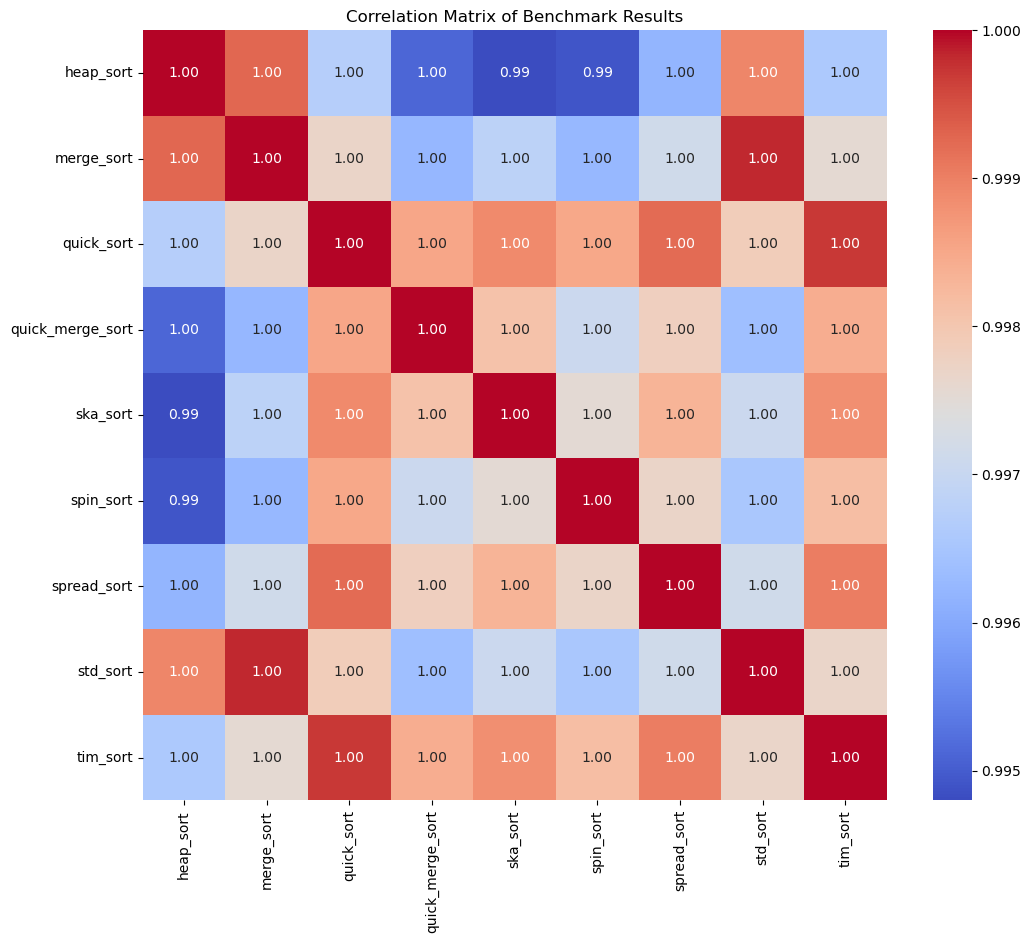

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df.drop(columns=['data', 'counting_sort']).corr()

print(corr_matrix)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Benchmark Results")
plt.show()

In [11]:
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
upper_tri = corr_matrix.where(mask)
sorted_corrs = upper_tri.stack().abs().sort_values(ascending=False)

print("Highest correlations between sorter benchmarks:")
print(sorted_corrs)

Highest correlations between sorter benchmarks:
spin_sort   std_sort      0.999928
            tim_sort      0.999912
std_sort    tim_sort      0.999904
quick_sort  spin_sort     0.999880
            tim_sort      0.999867
                            ...   
mel_sort    slab_sort     0.955378
            spin_sort     0.955358
            merge_sort    0.954673
            std_sort      0.954493
            ska_sort      0.947086
Length: 78, dtype: float64


High correlation pairs (corr > 0.9):
heap_sort and merge_sort (corr = 1.00)
heap_sort and quick_sort (corr = 1.00)
heap_sort and quick_merge_sort (corr = 1.00)
heap_sort and ska_sort (corr = 0.99)
heap_sort and spin_sort (corr = 0.99)
heap_sort and spread_sort (corr = 1.00)
heap_sort and std_sort (corr = 1.00)
heap_sort and tim_sort (corr = 1.00)
merge_sort and quick_sort (corr = 1.00)
merge_sort and quick_merge_sort (corr = 1.00)
merge_sort and ska_sort (corr = 1.00)
merge_sort and spin_sort (corr = 1.00)
merge_sort and spread_sort (corr = 1.00)
merge_sort and std_sort (corr = 1.00)
merge_sort and tim_sort (corr = 1.00)
quick_sort and quick_merge_sort (corr = 1.00)
quick_sort and ska_sort (corr = 1.00)
quick_sort and spin_sort (corr = 1.00)
quick_sort and spread_sort (corr = 1.00)
quick_sort and std_sort (corr = 1.00)
quick_sort and tim_sort (corr = 1.00)
quick_merge_sort and ska_sort (corr = 1.00)
quick_merge_sort and spin_sort (corr = 1.00)
quick_merge_sort and spread_sort (corr = 1

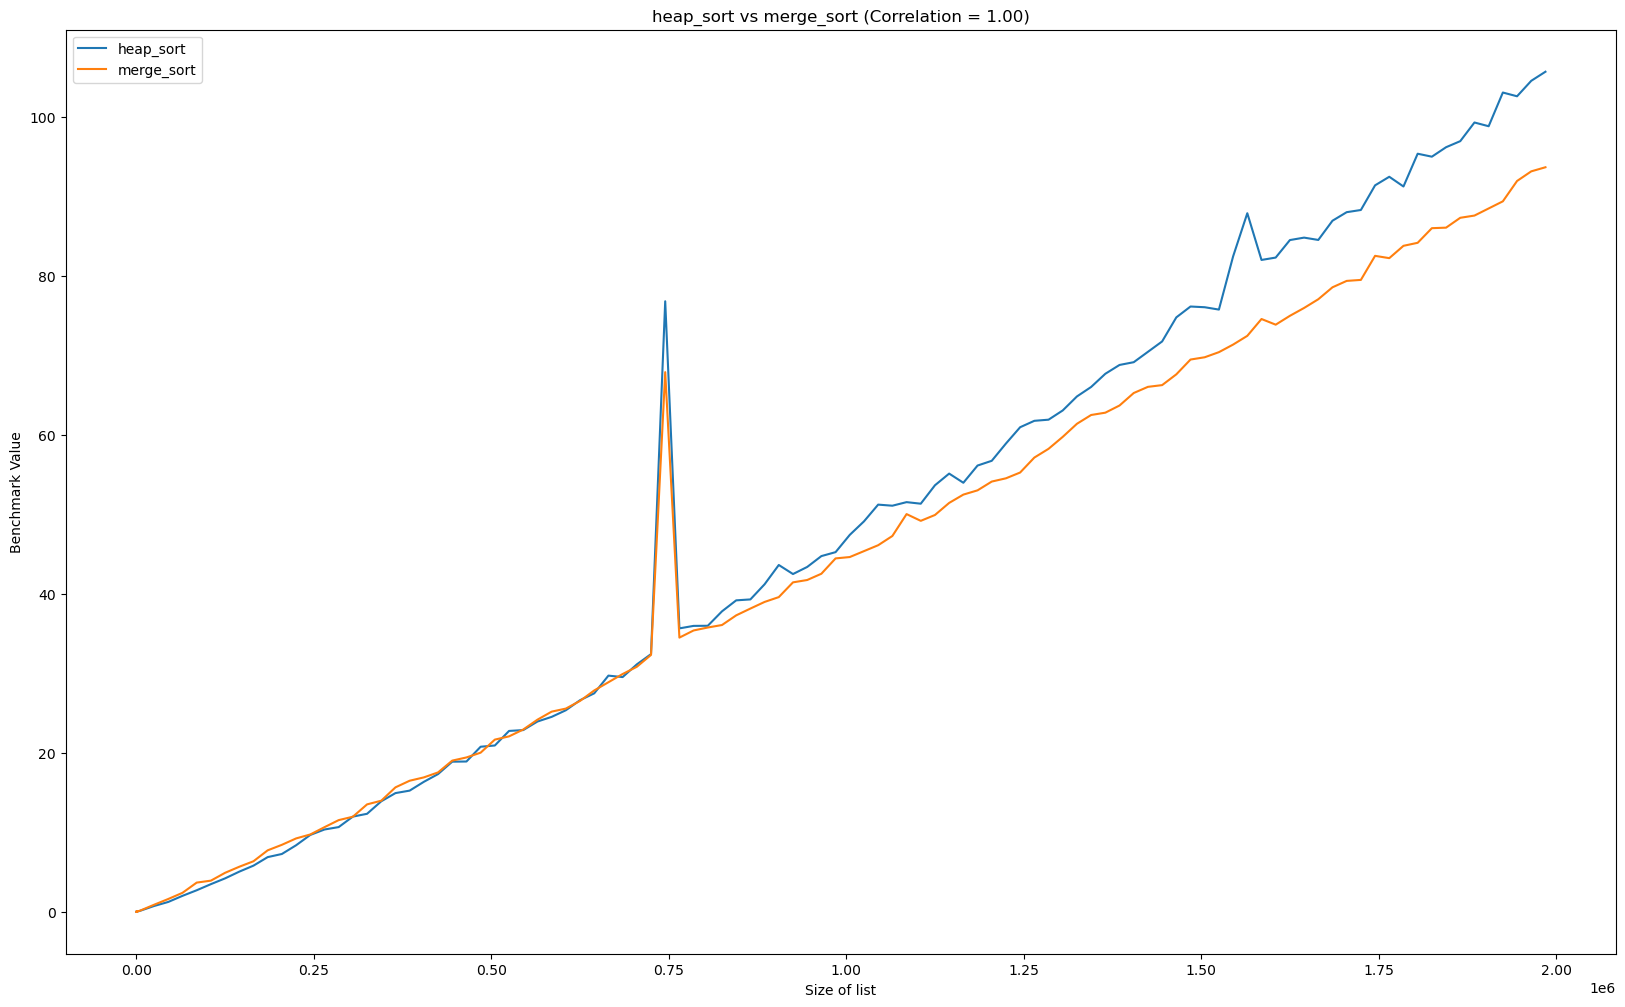

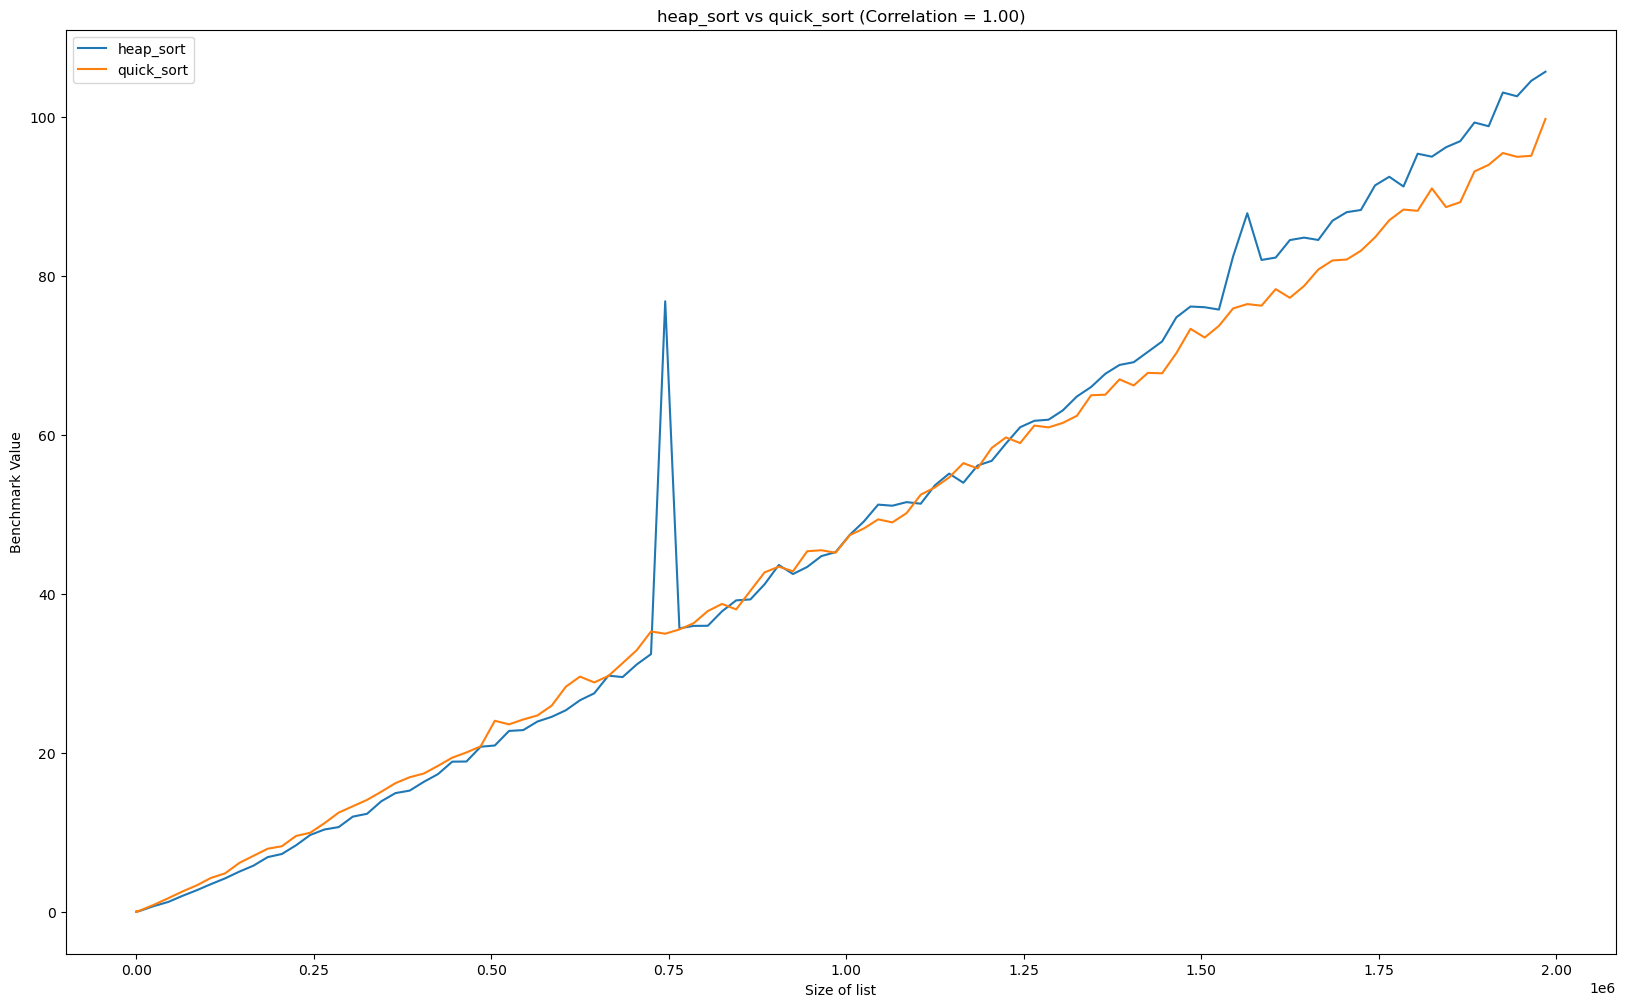

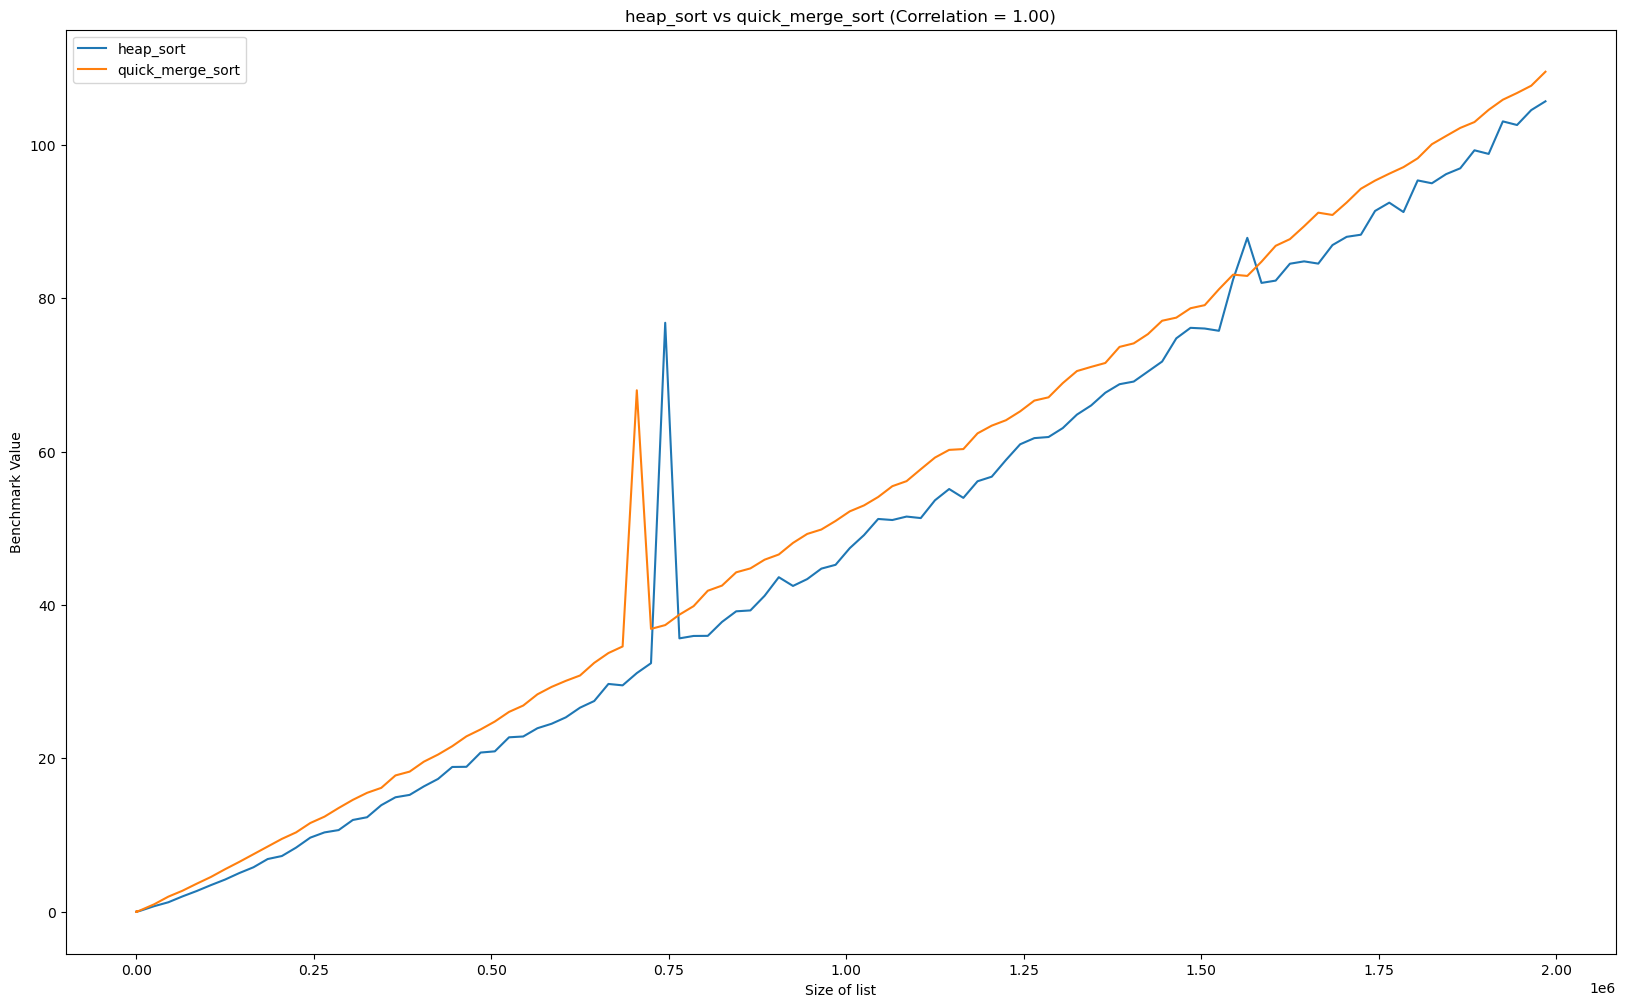

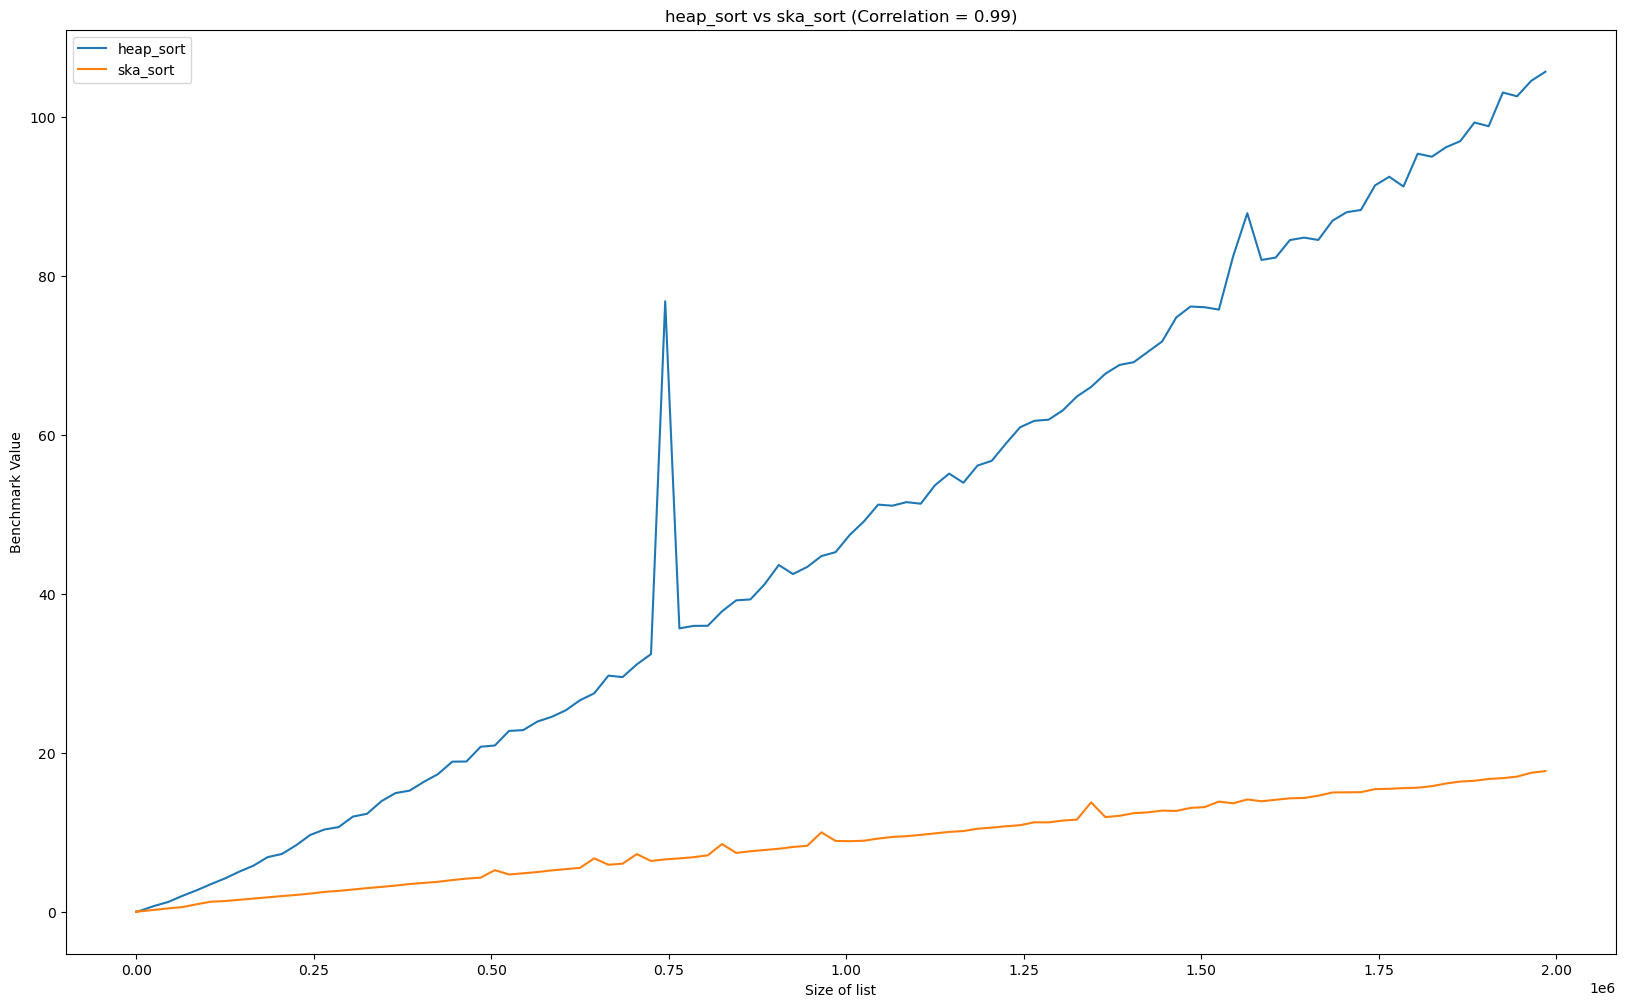

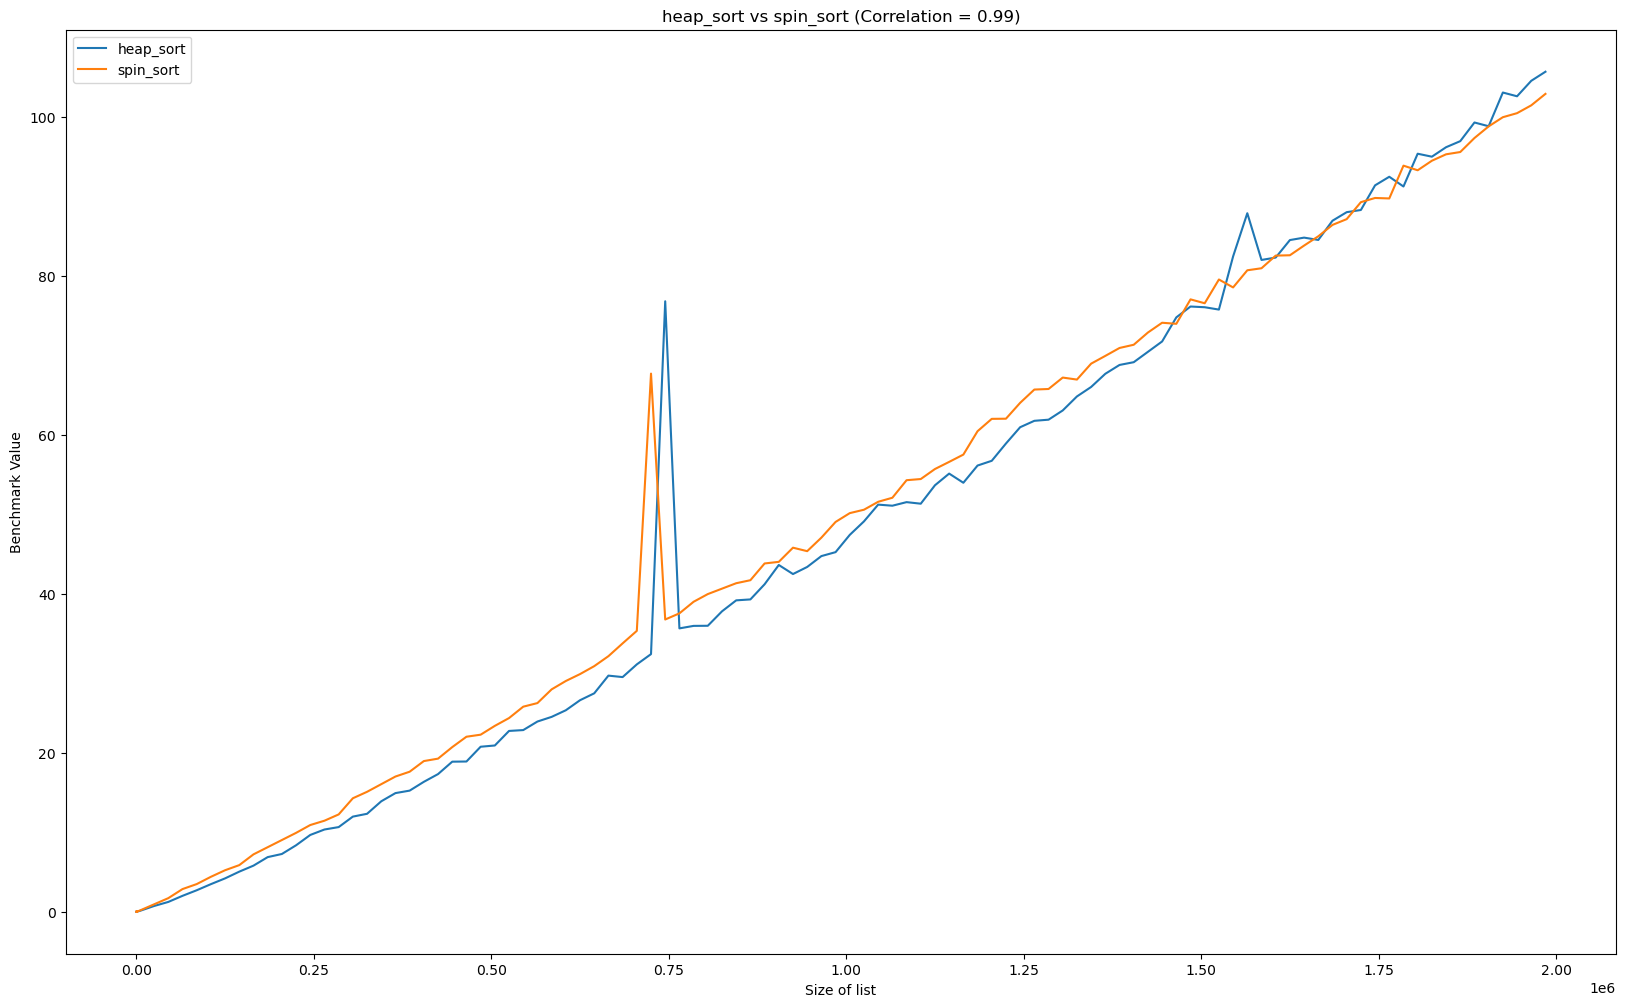

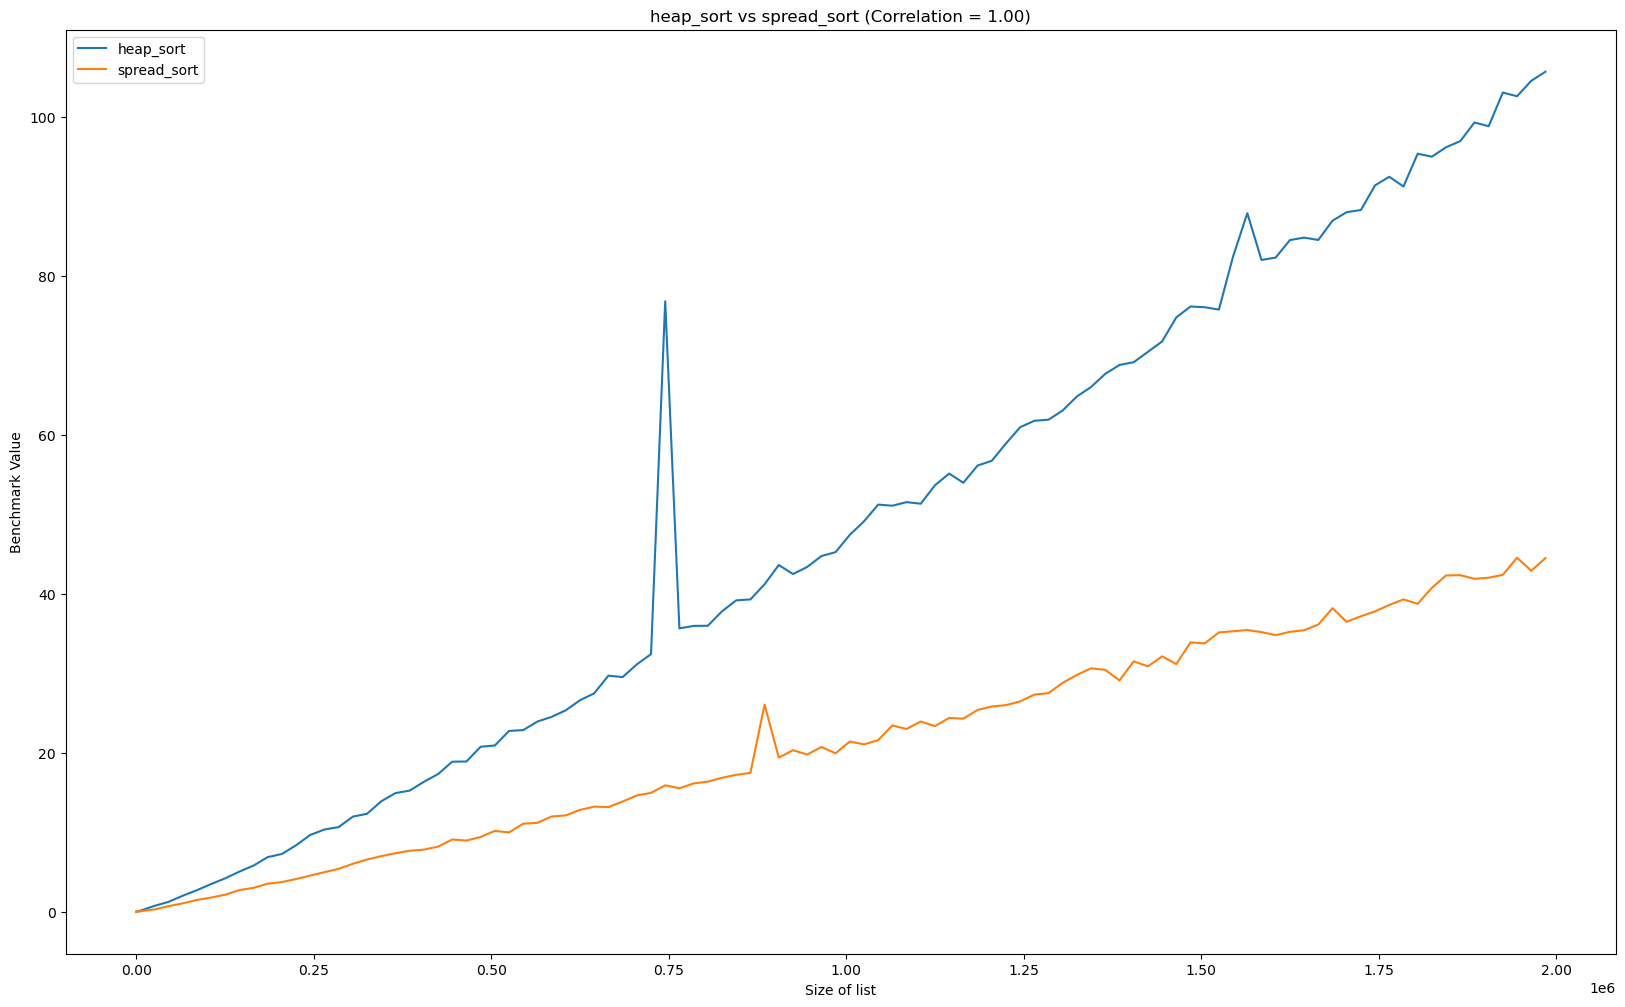

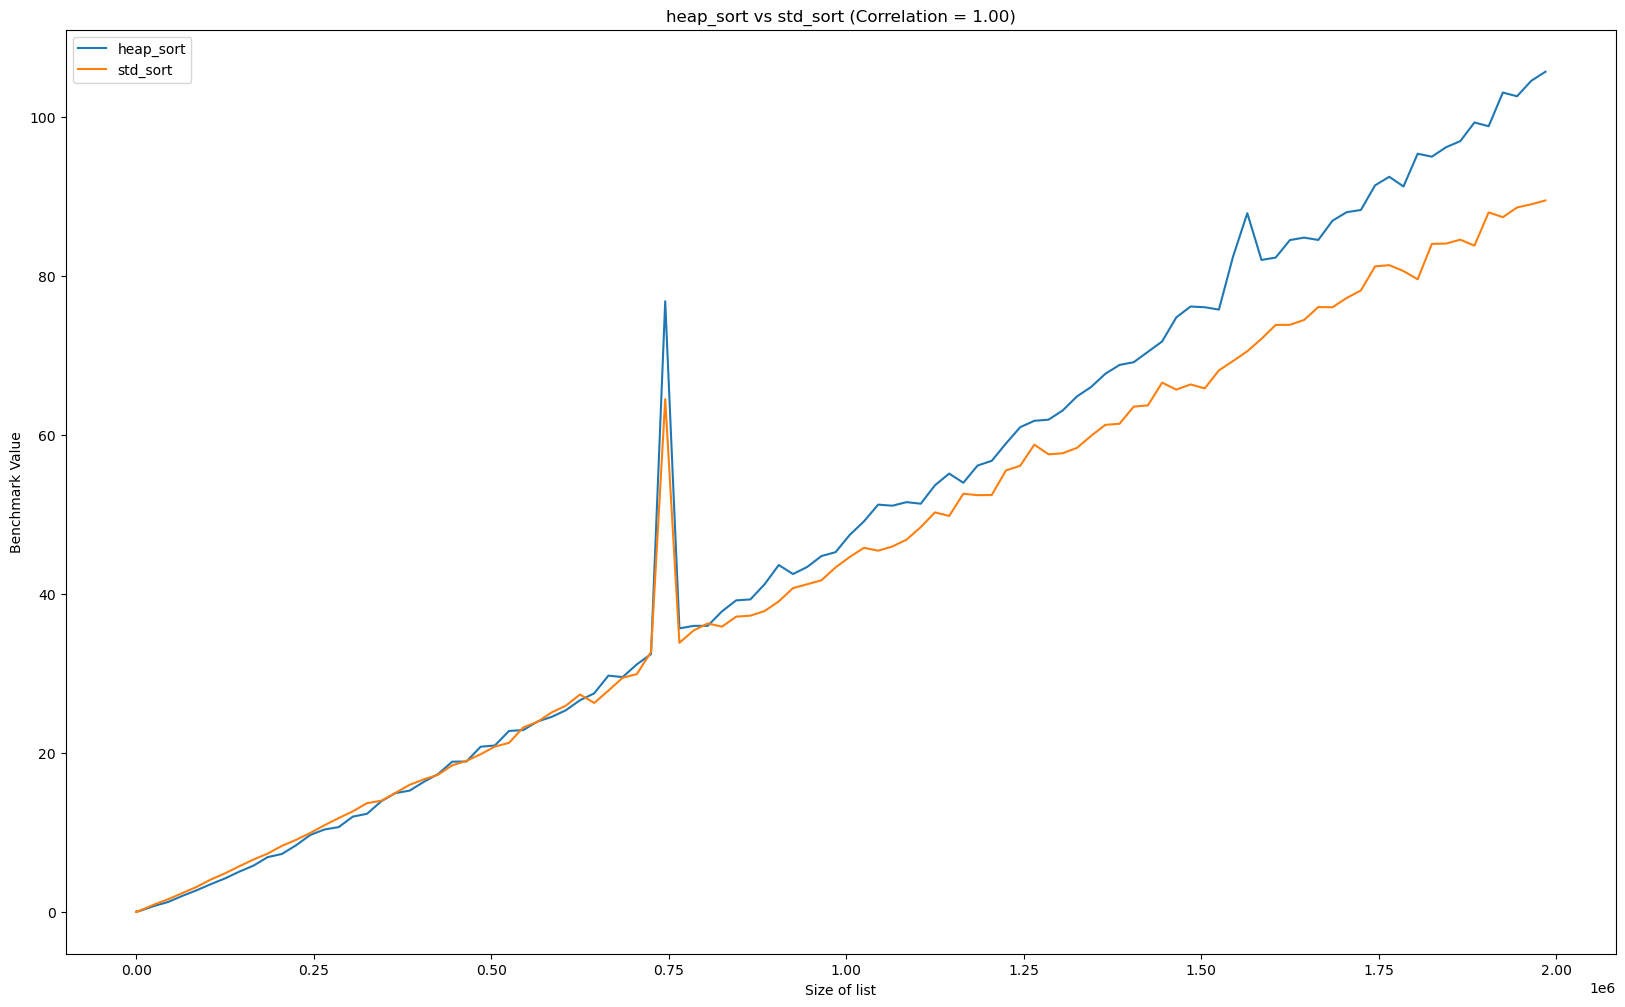

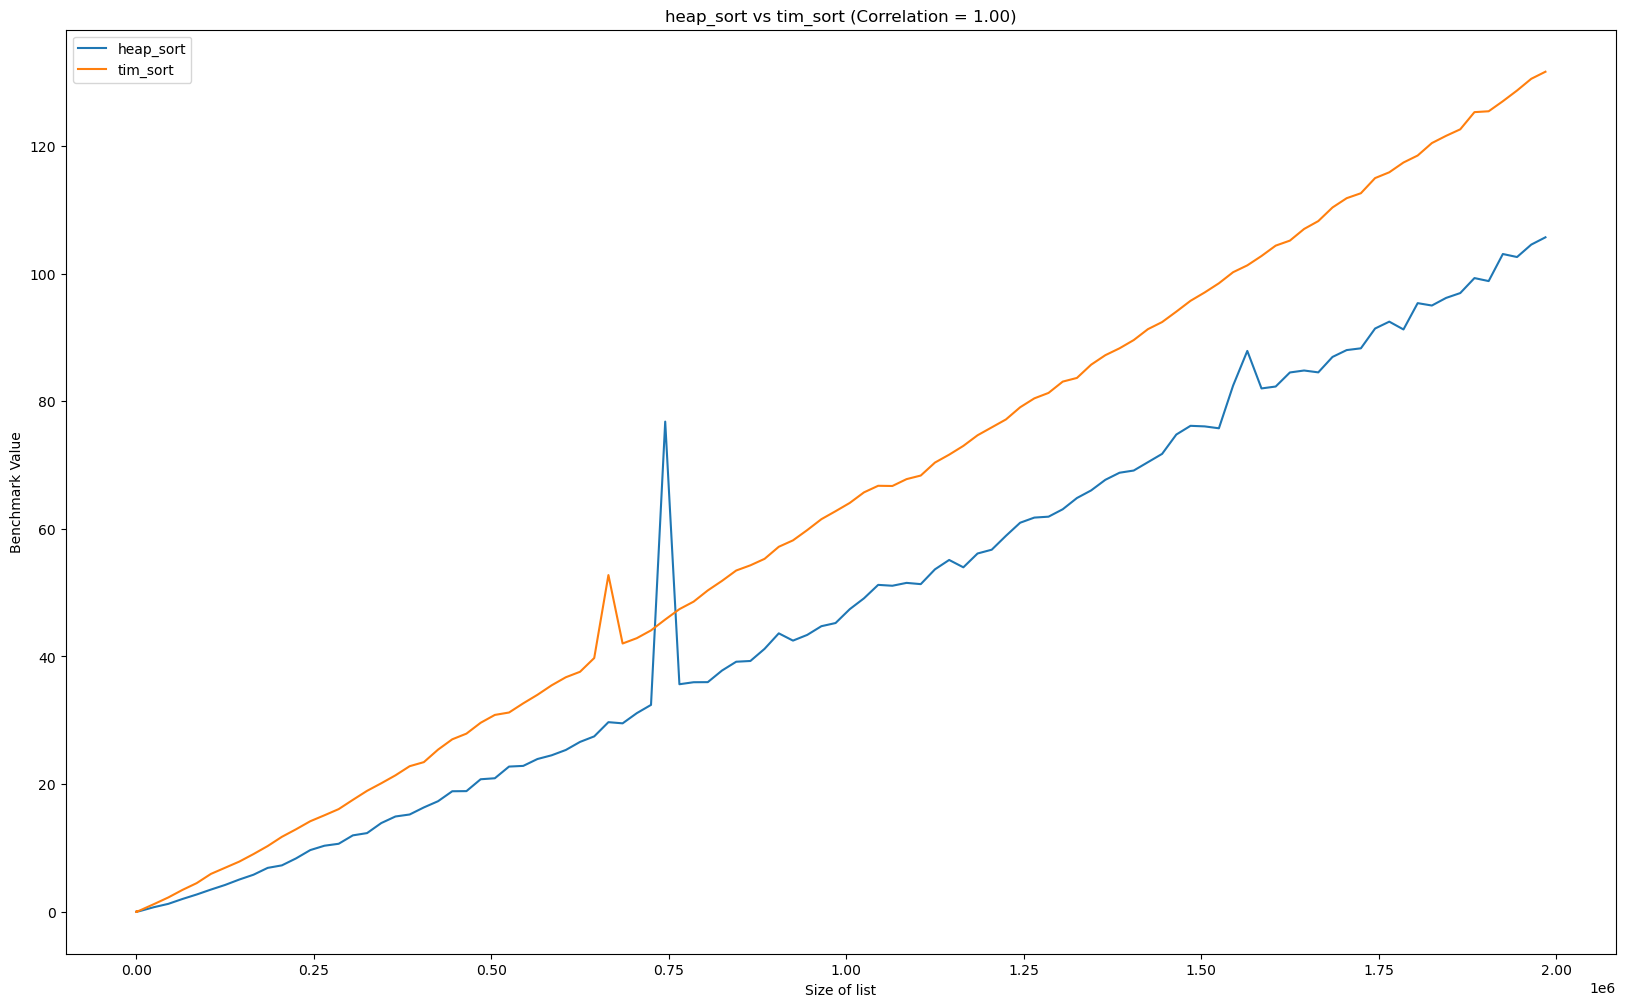

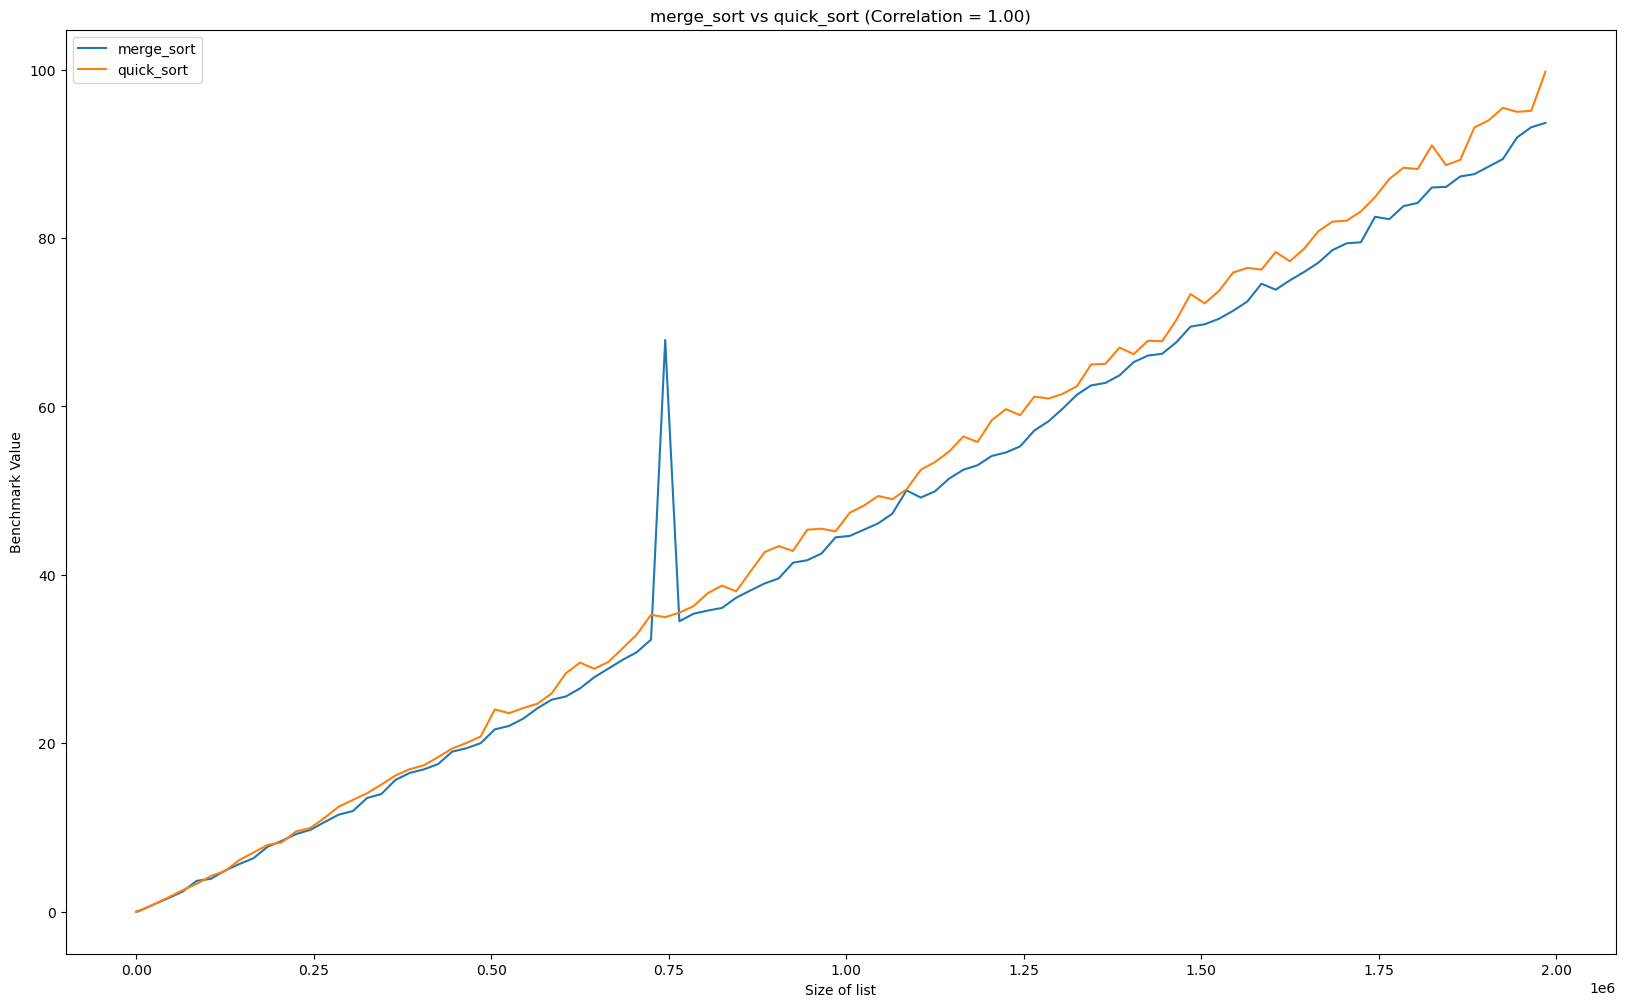

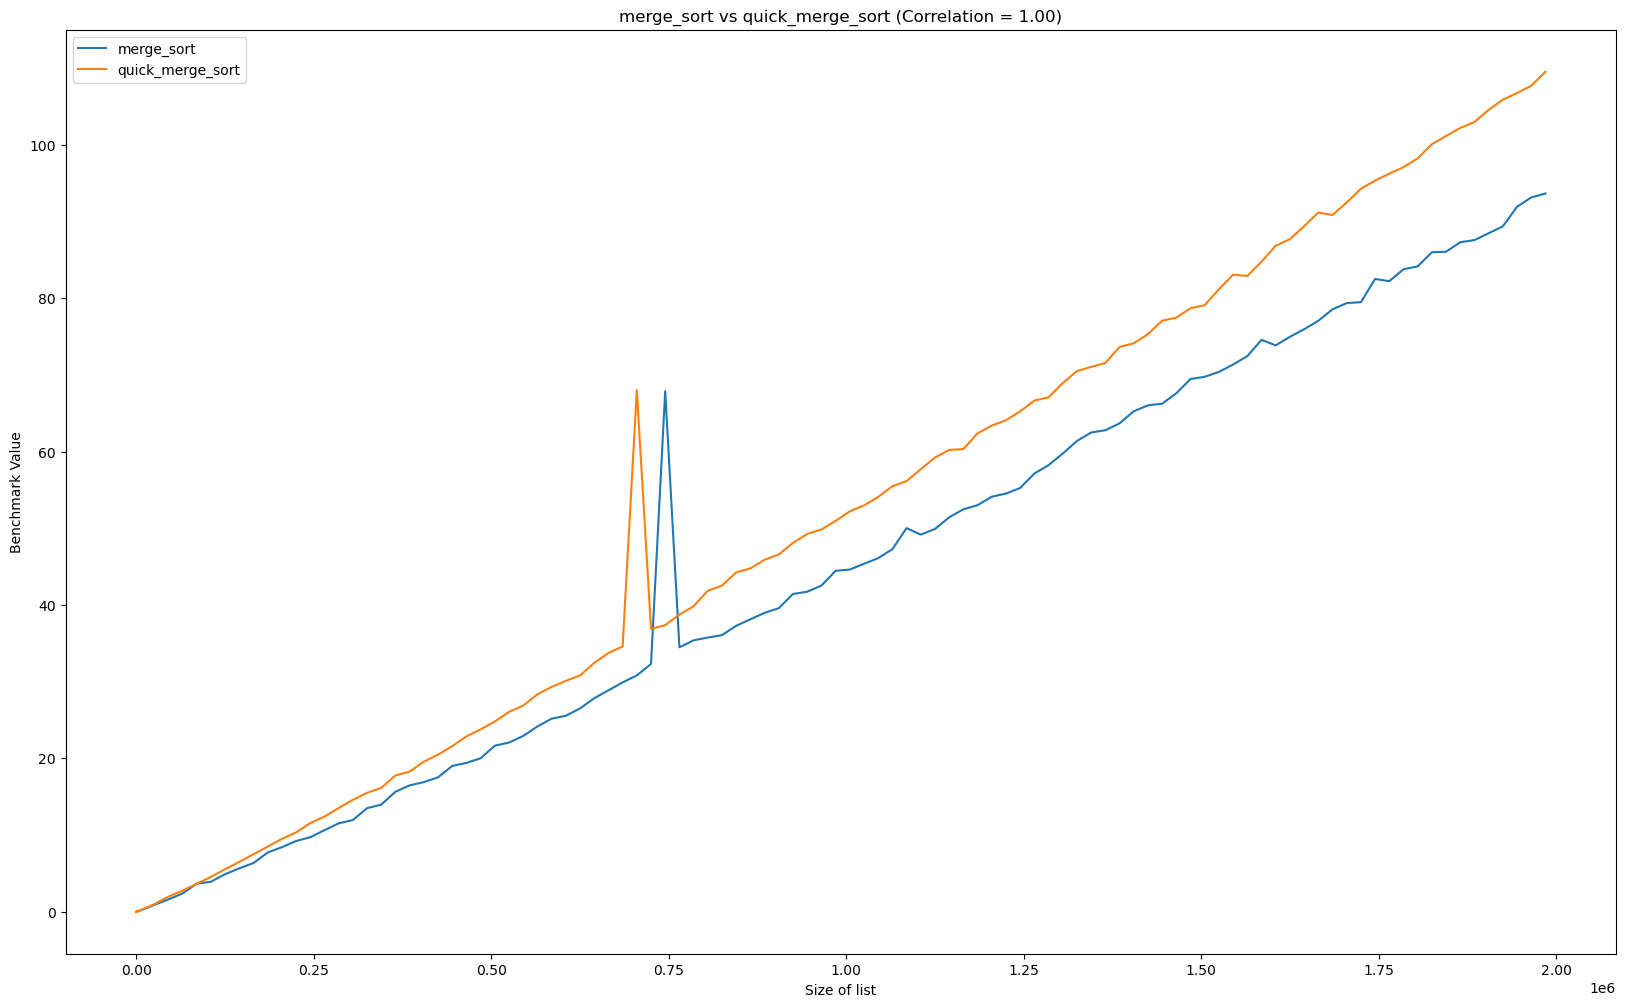

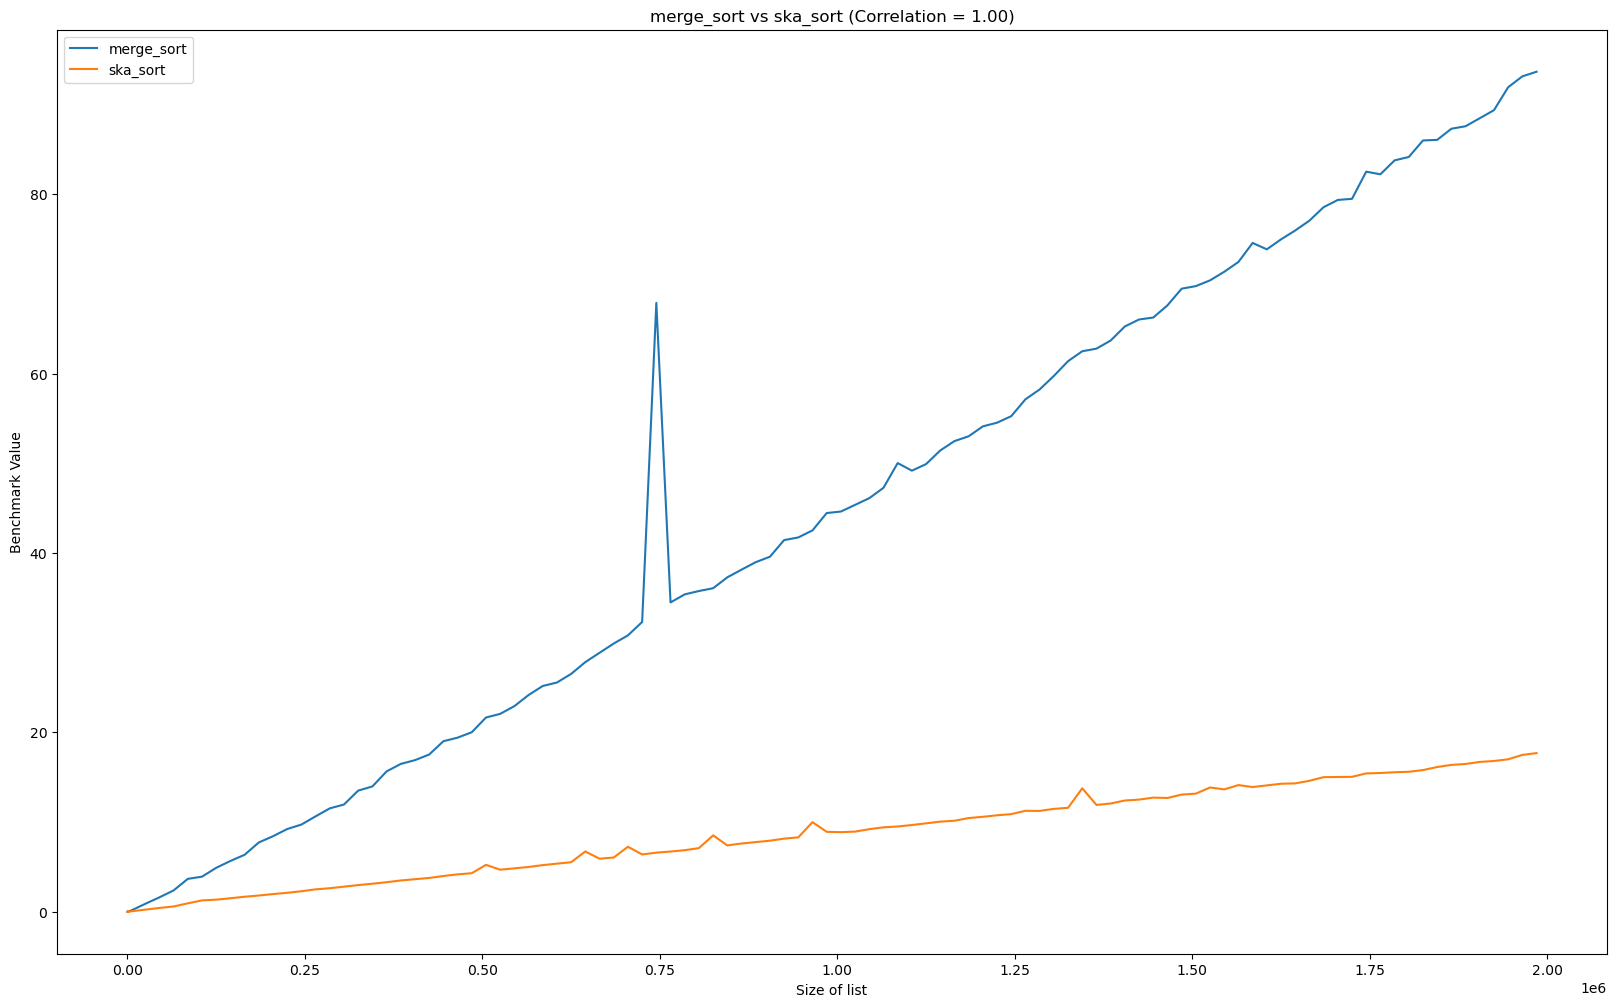

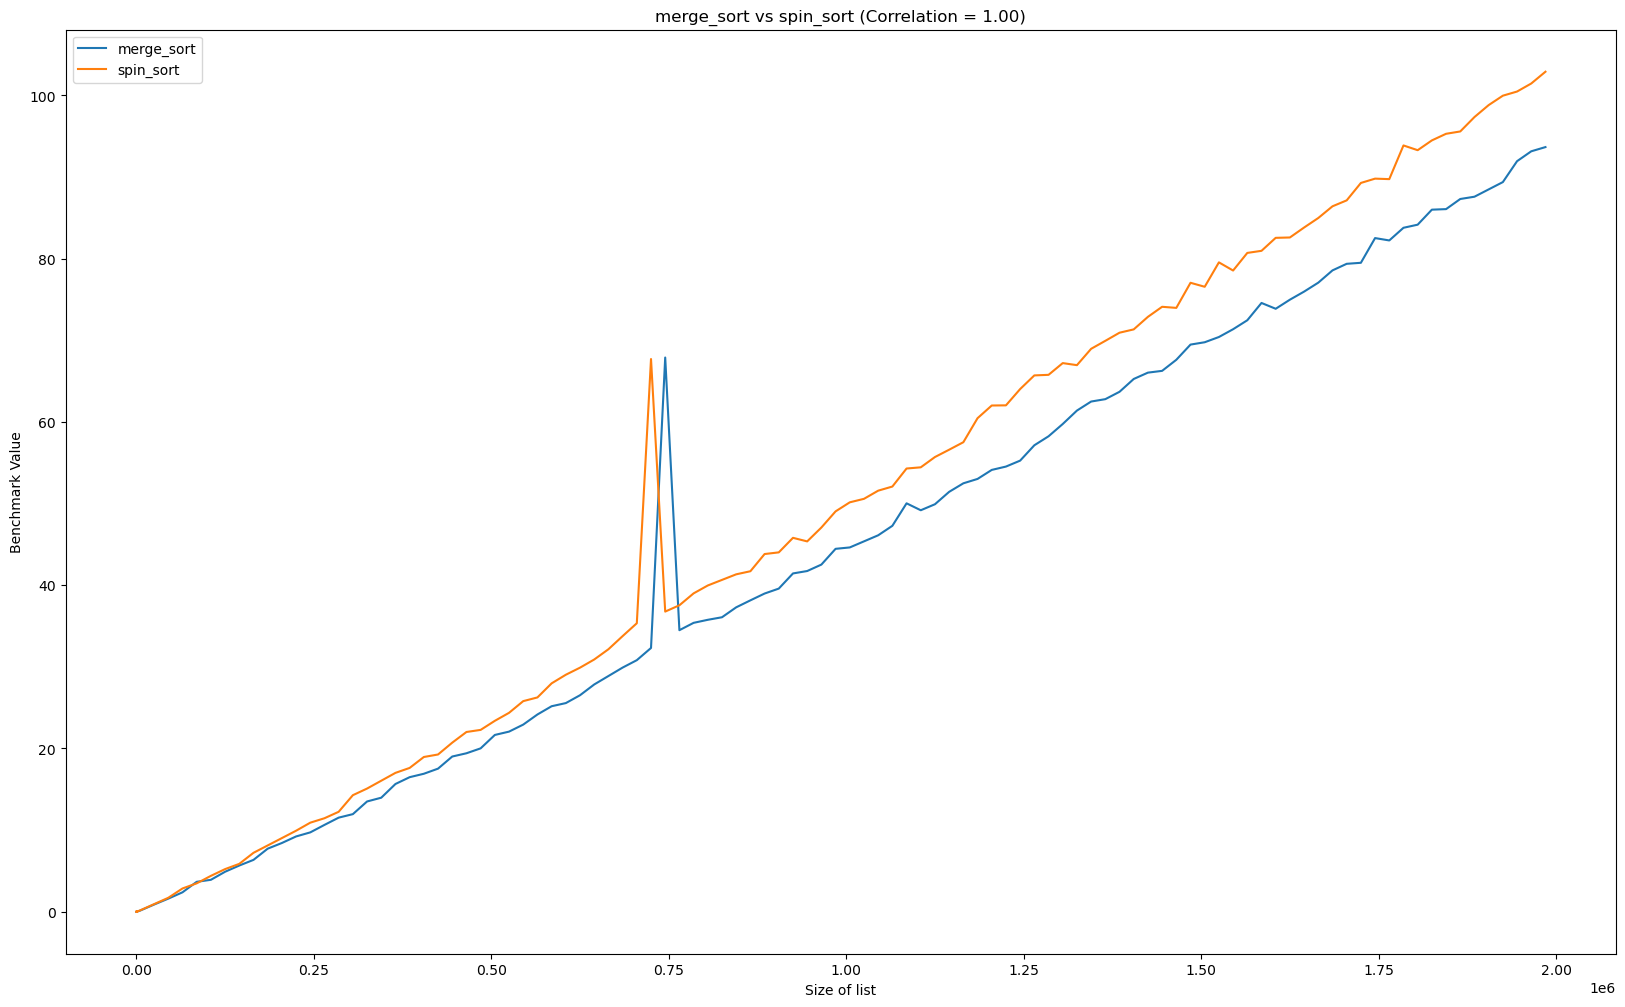

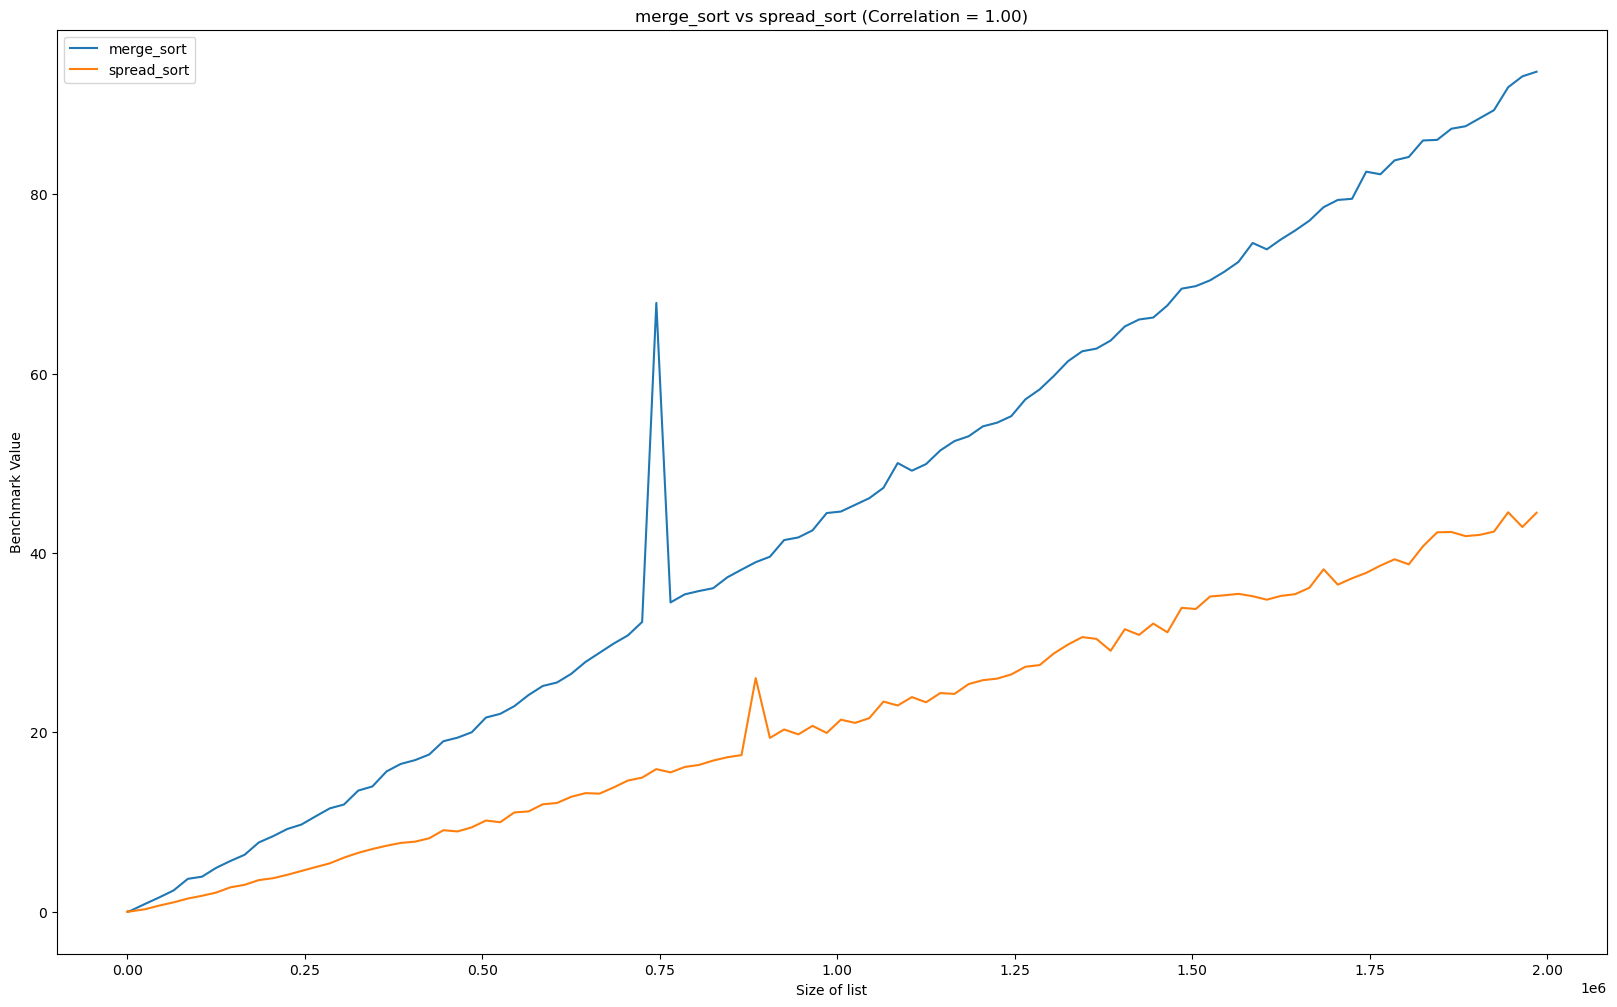

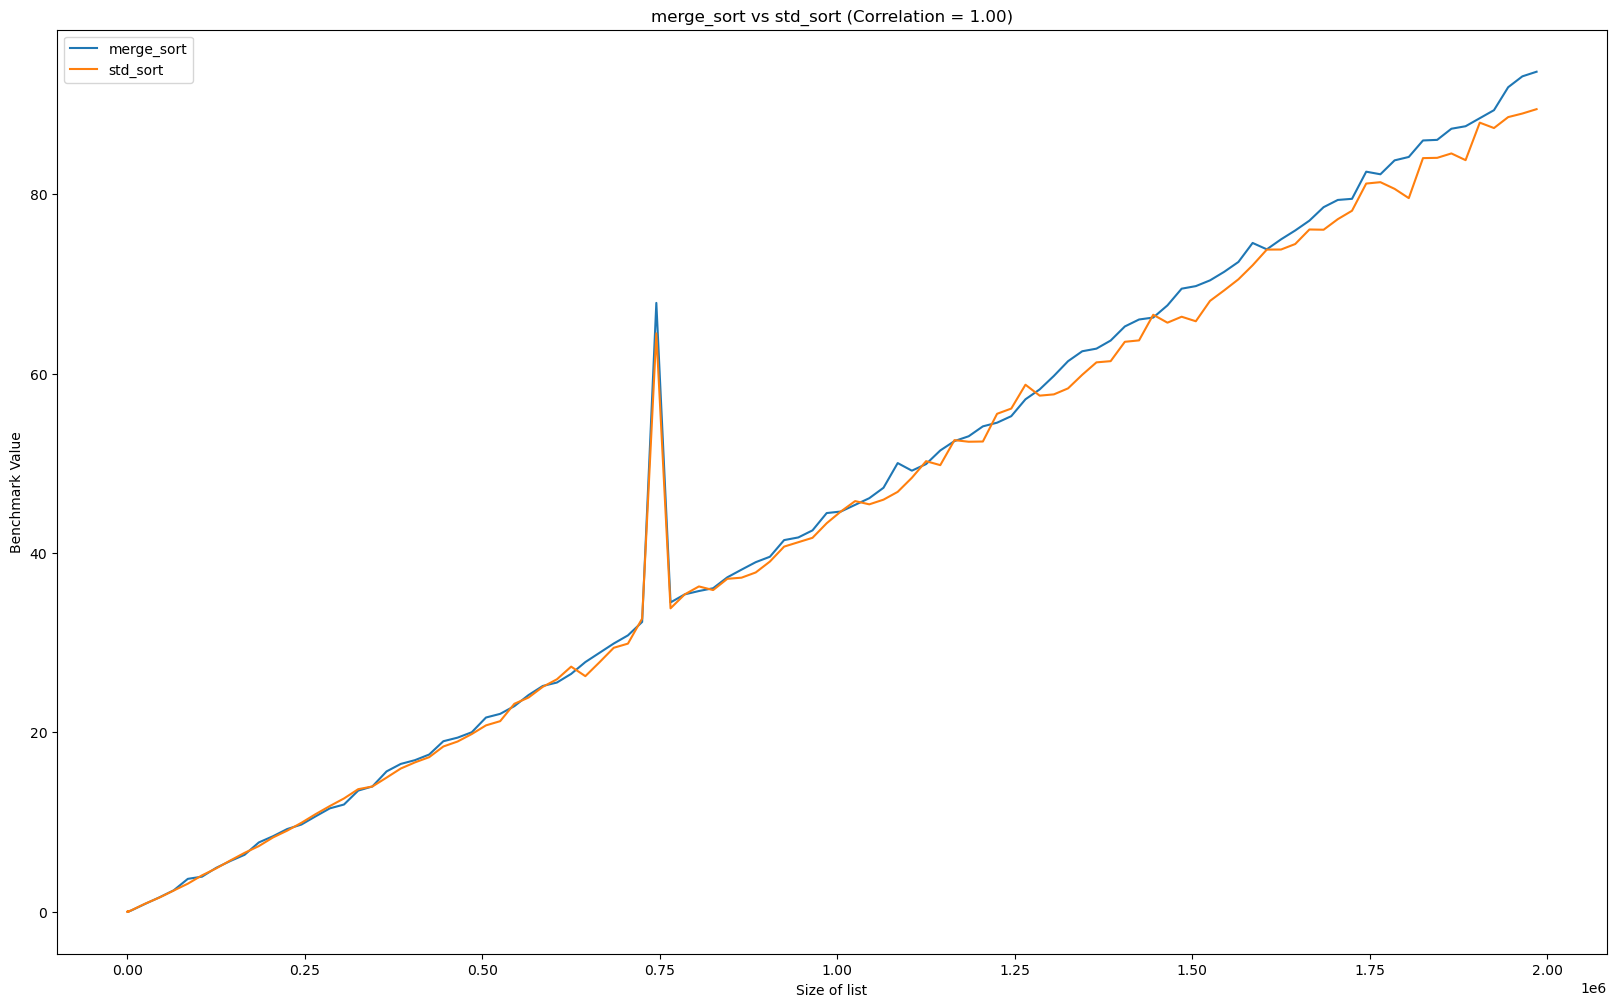

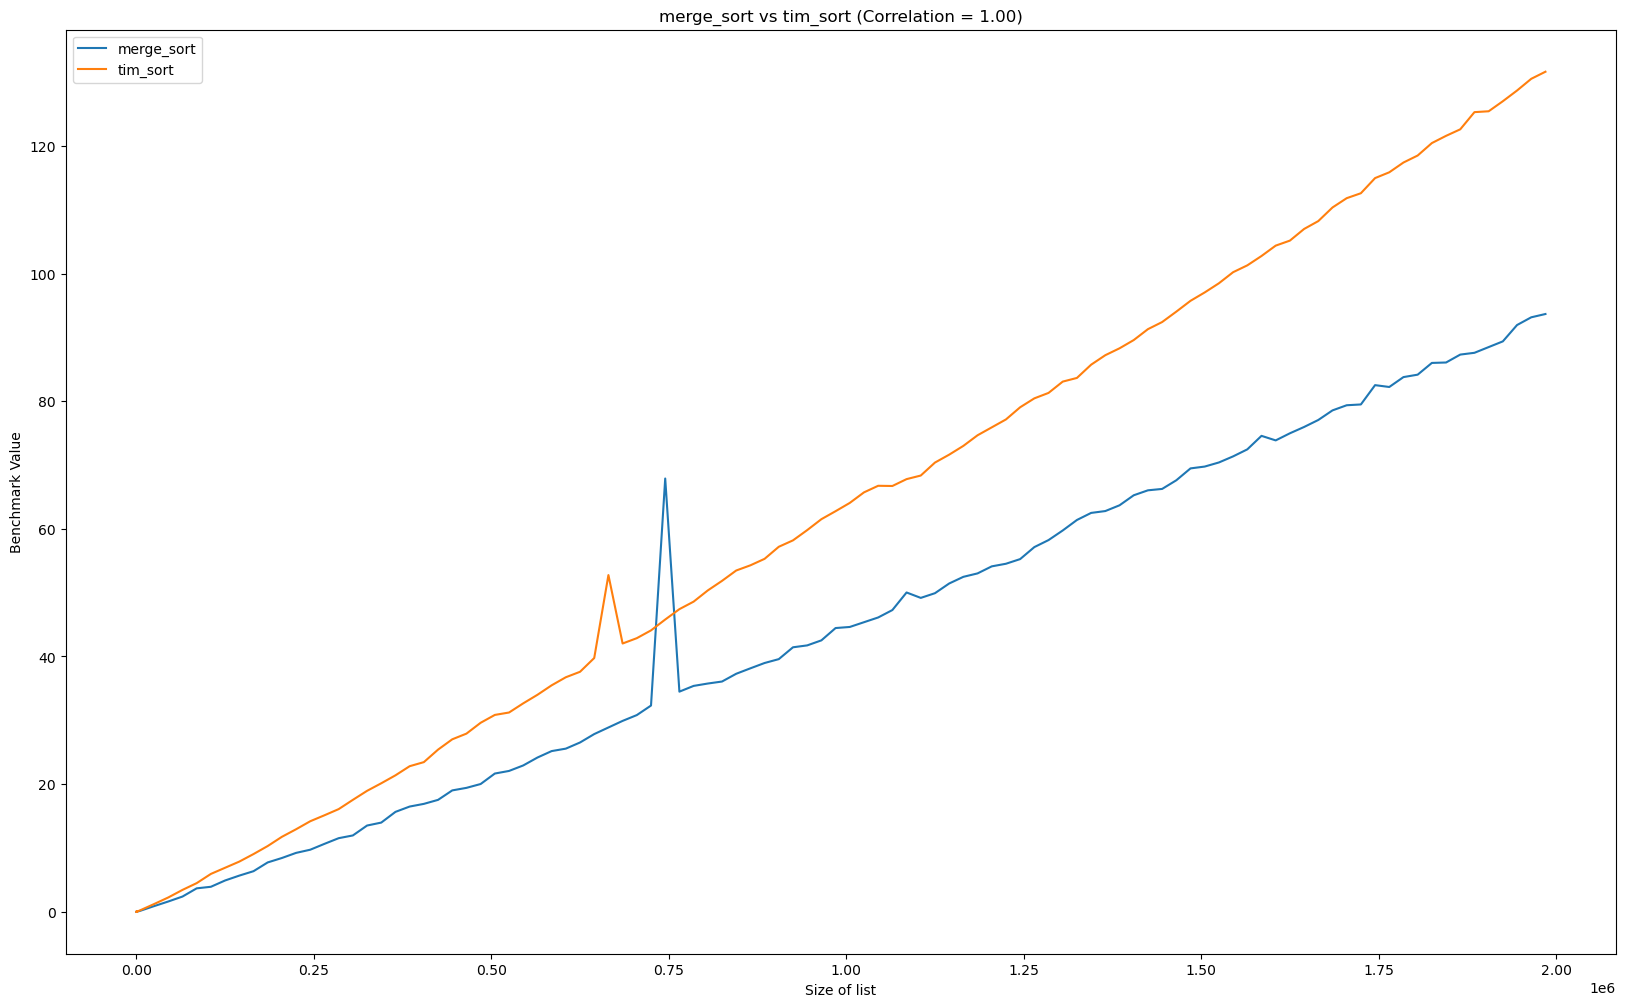

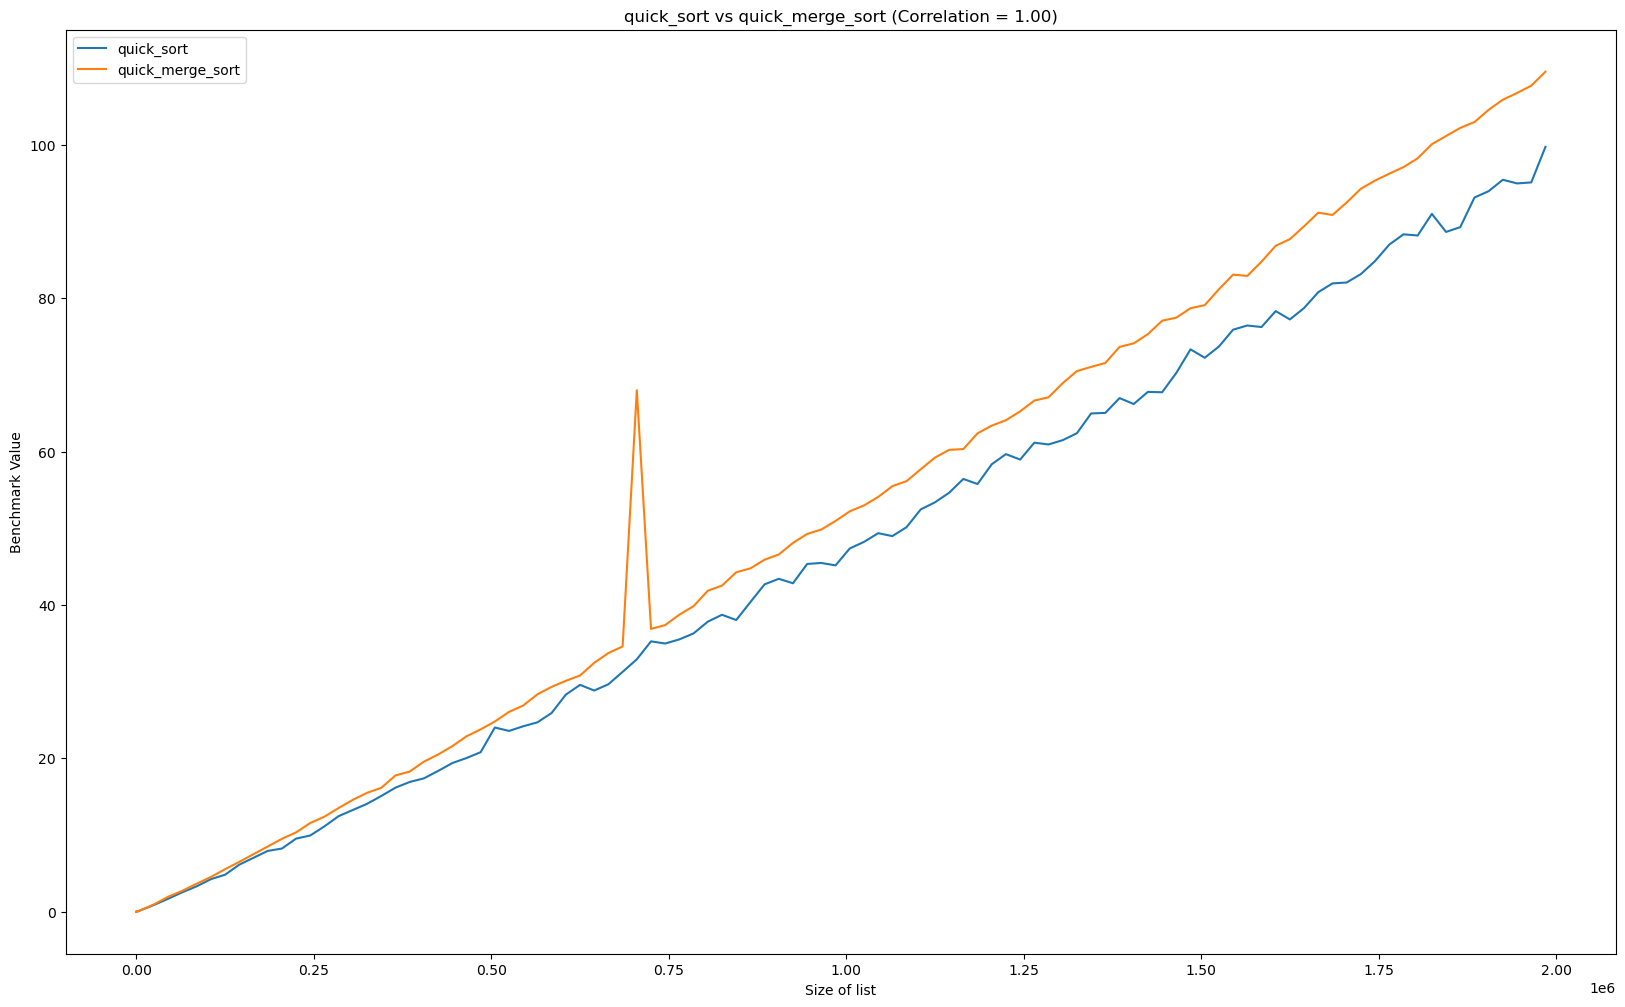

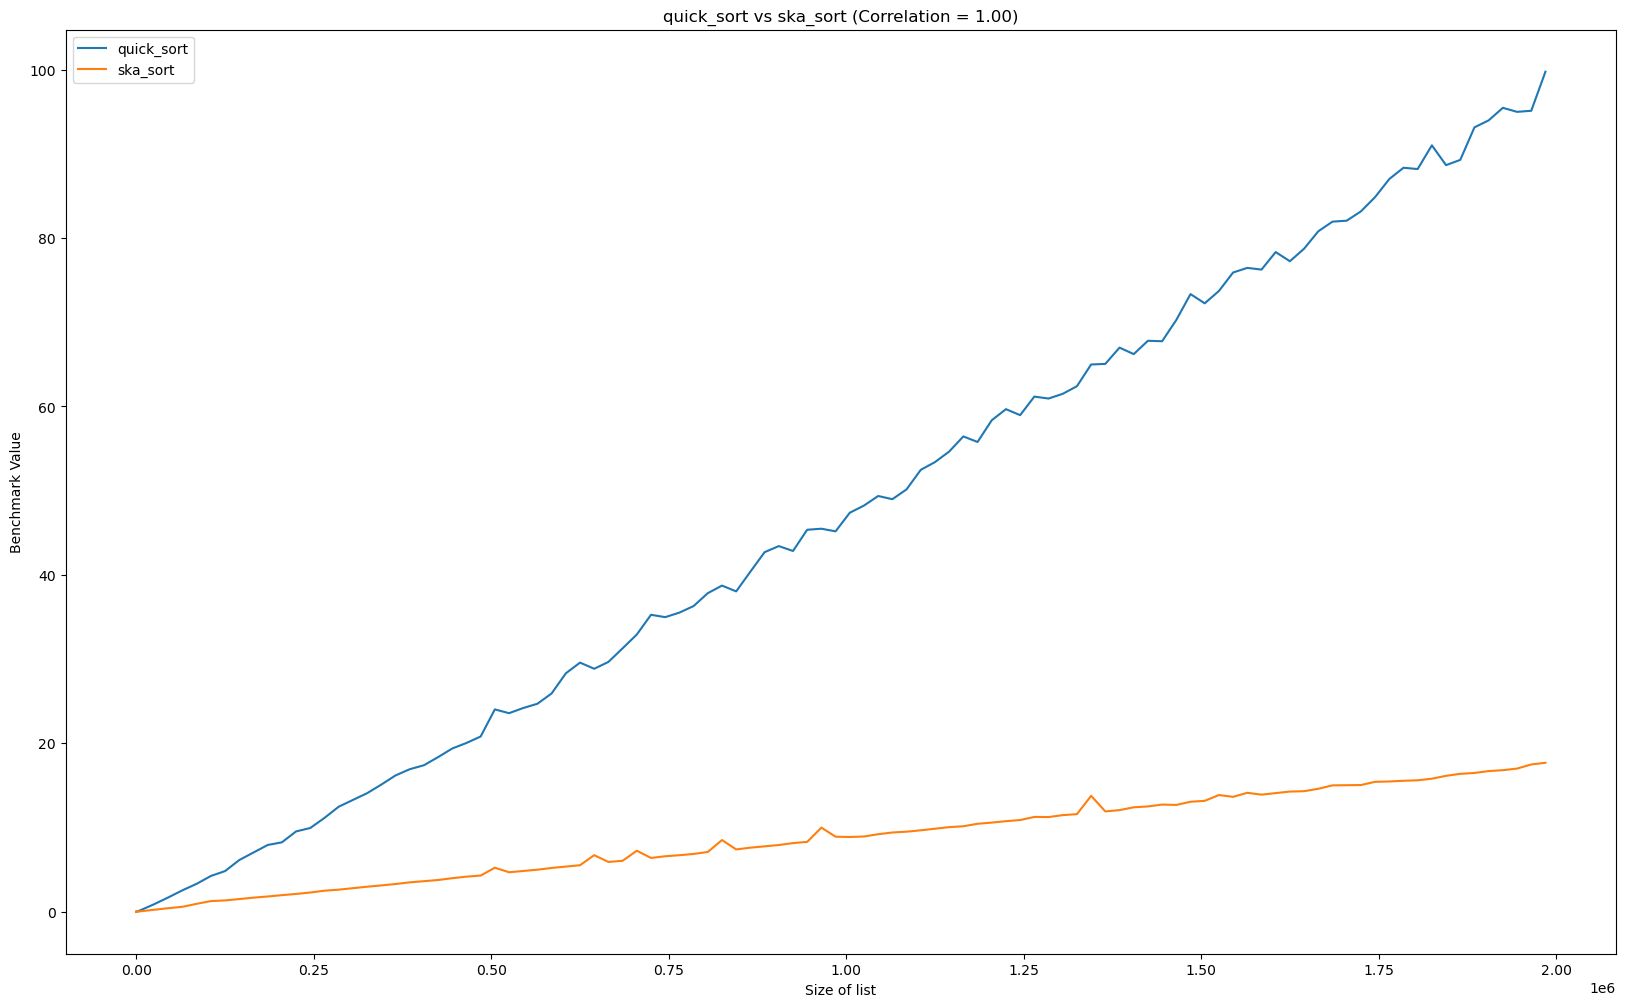

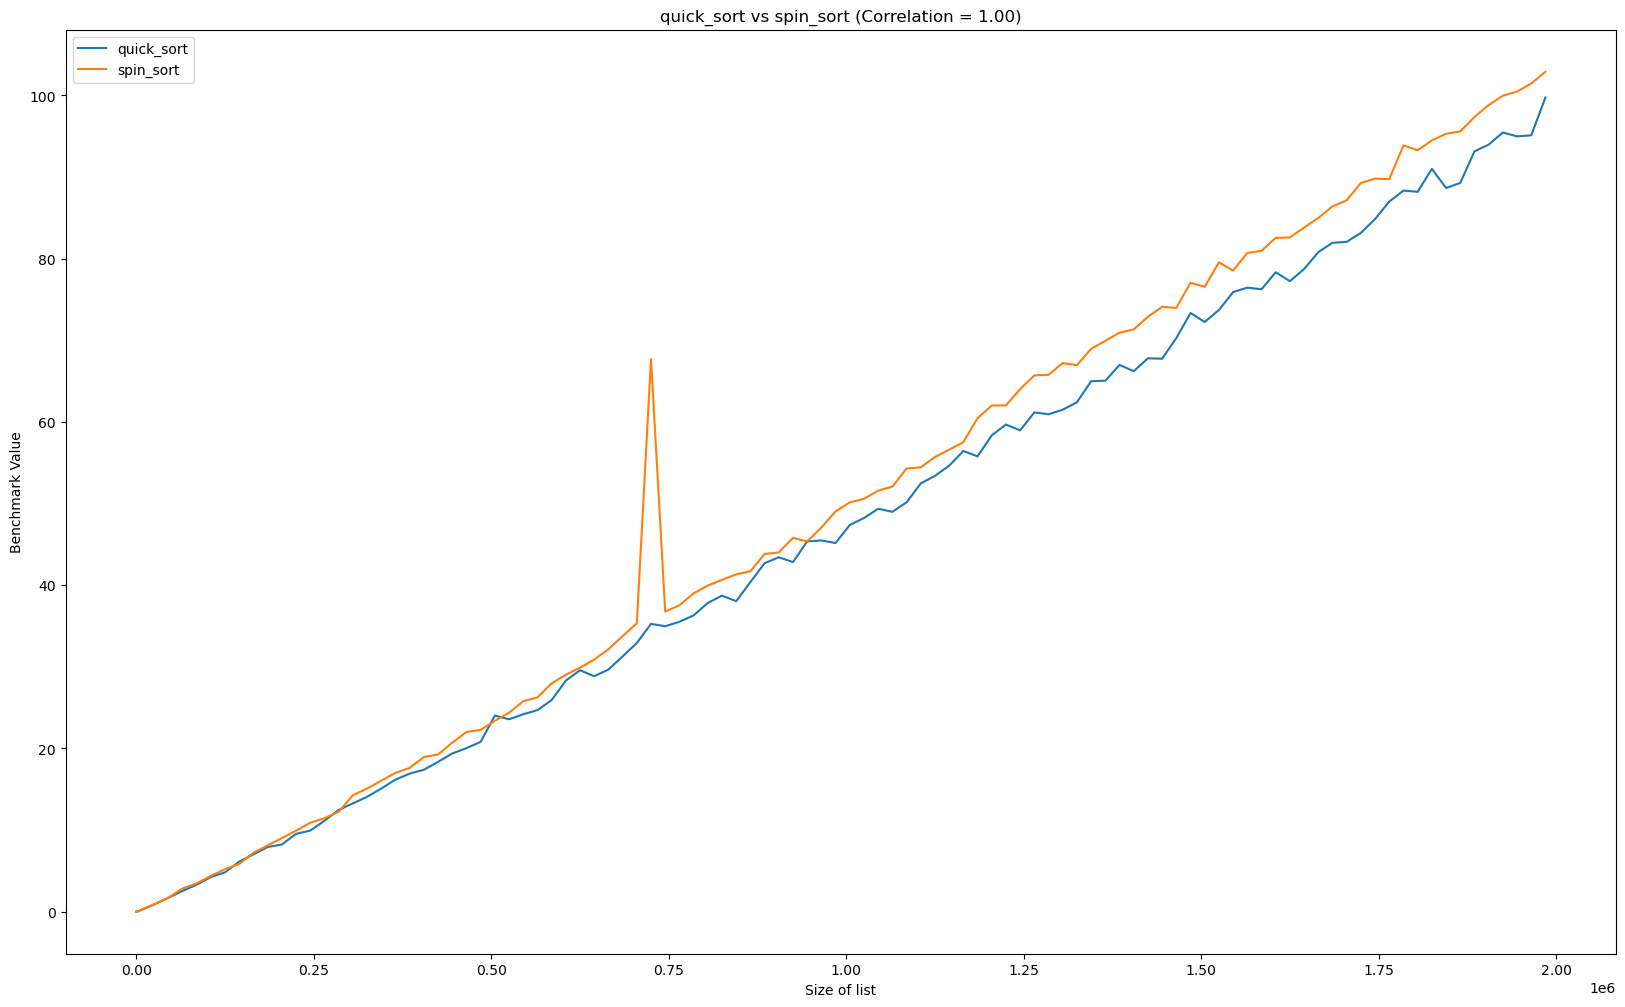

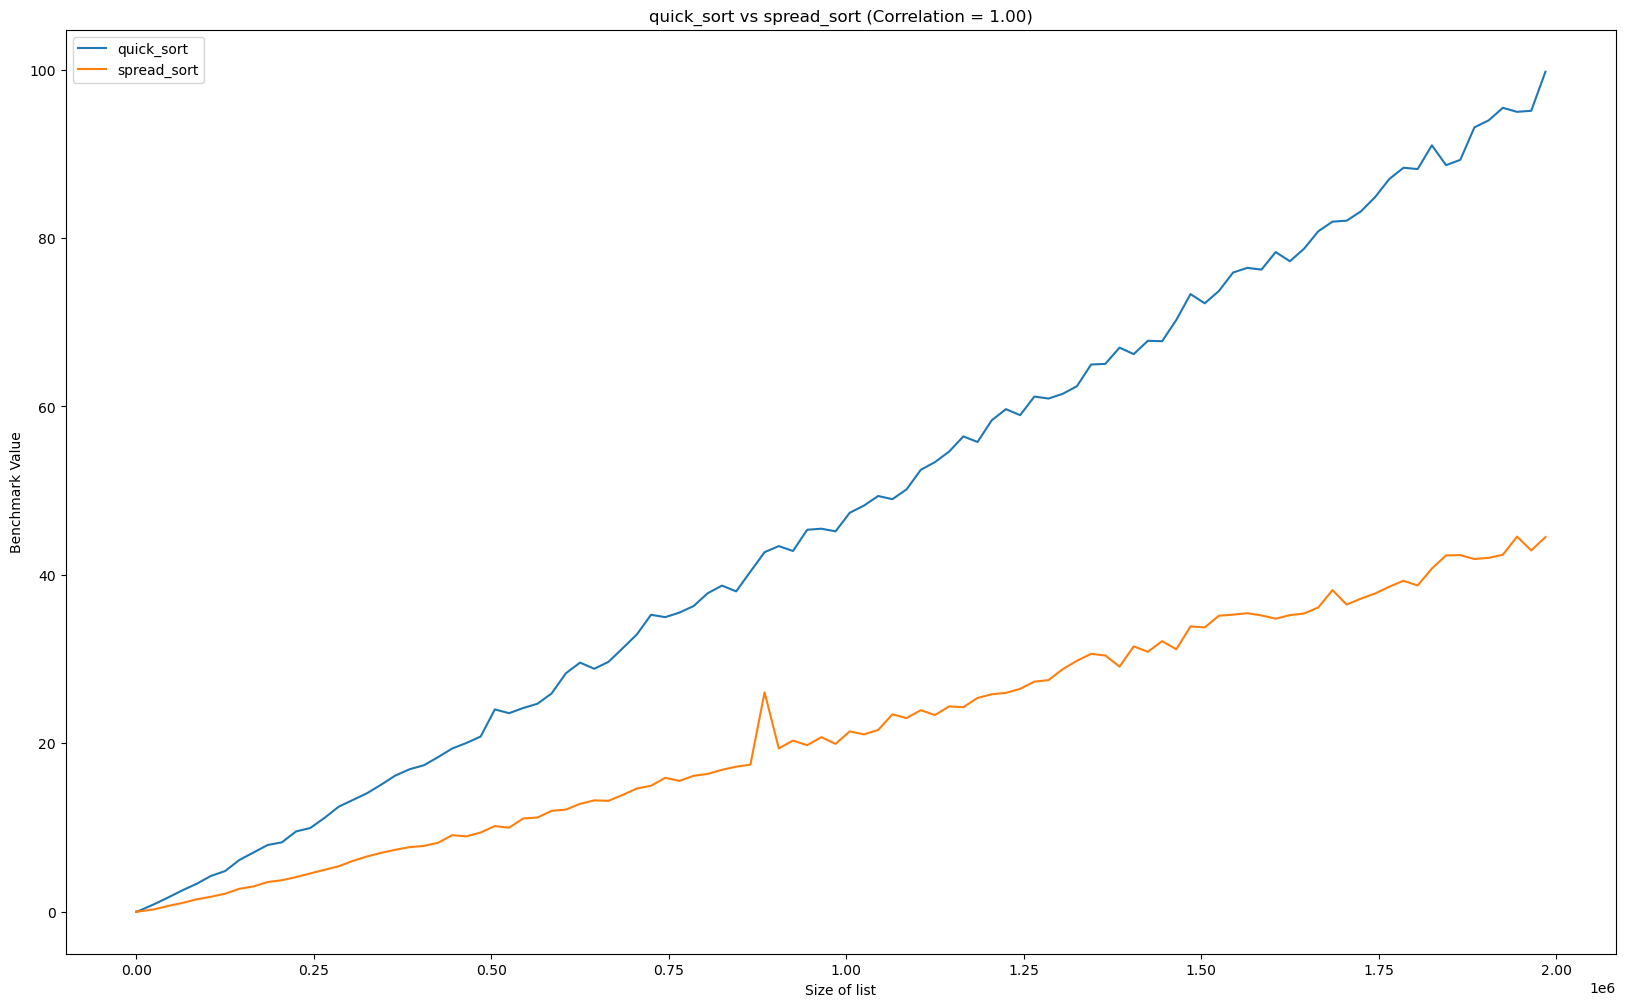

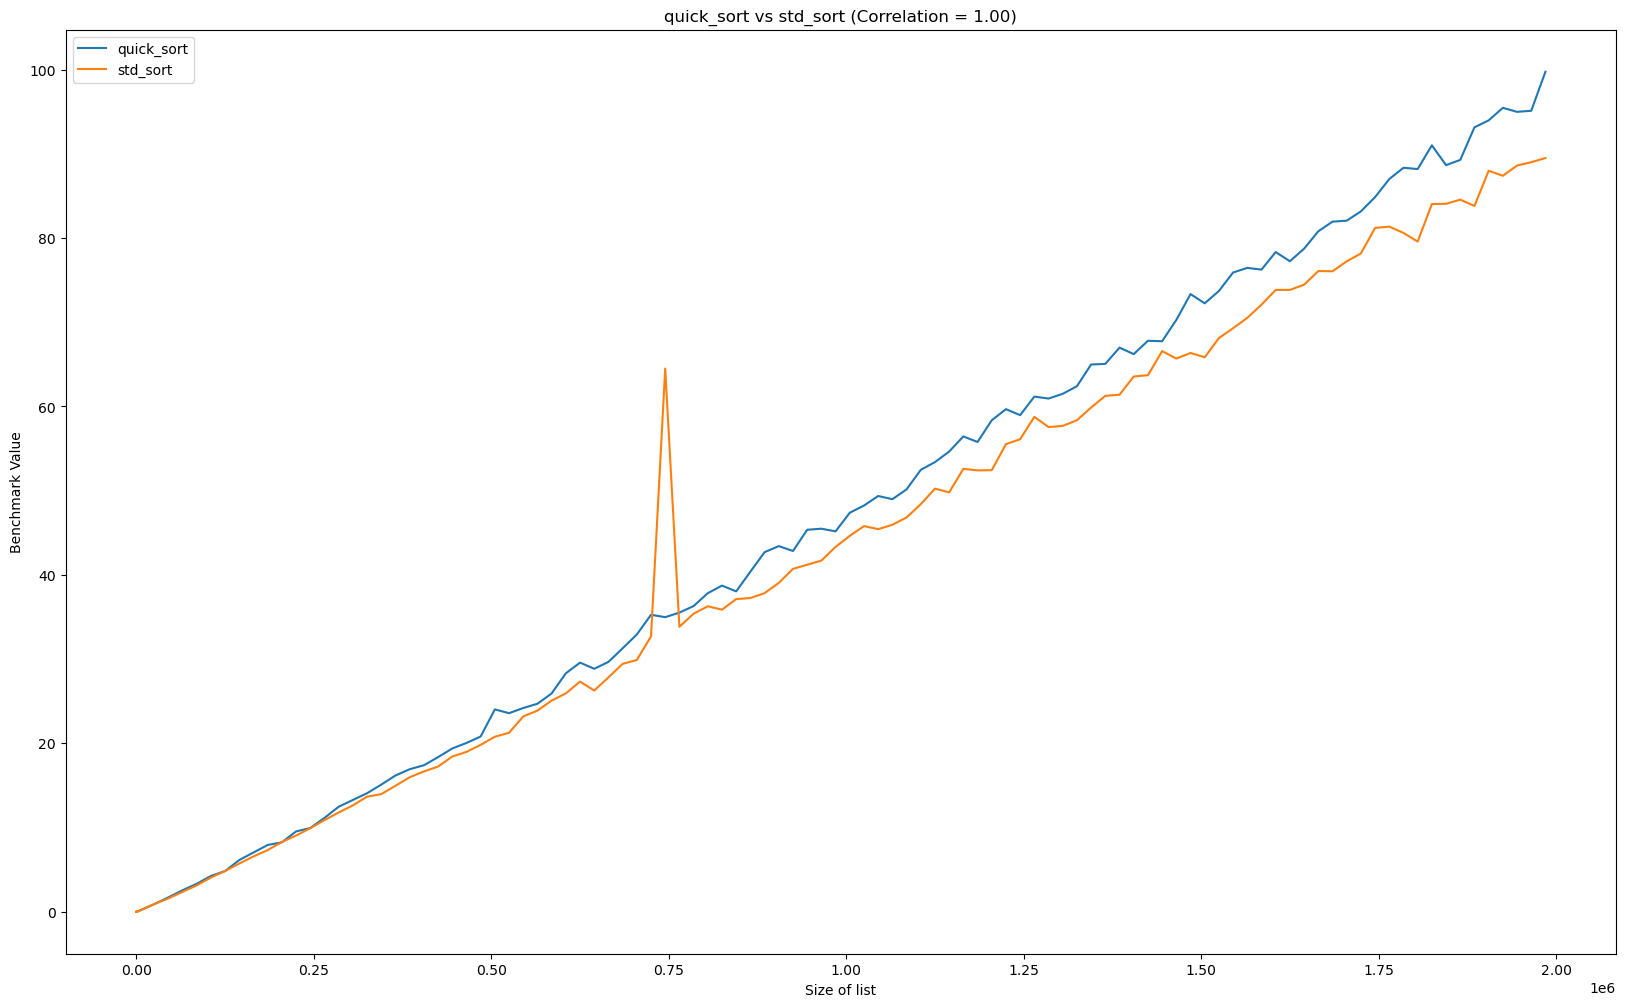

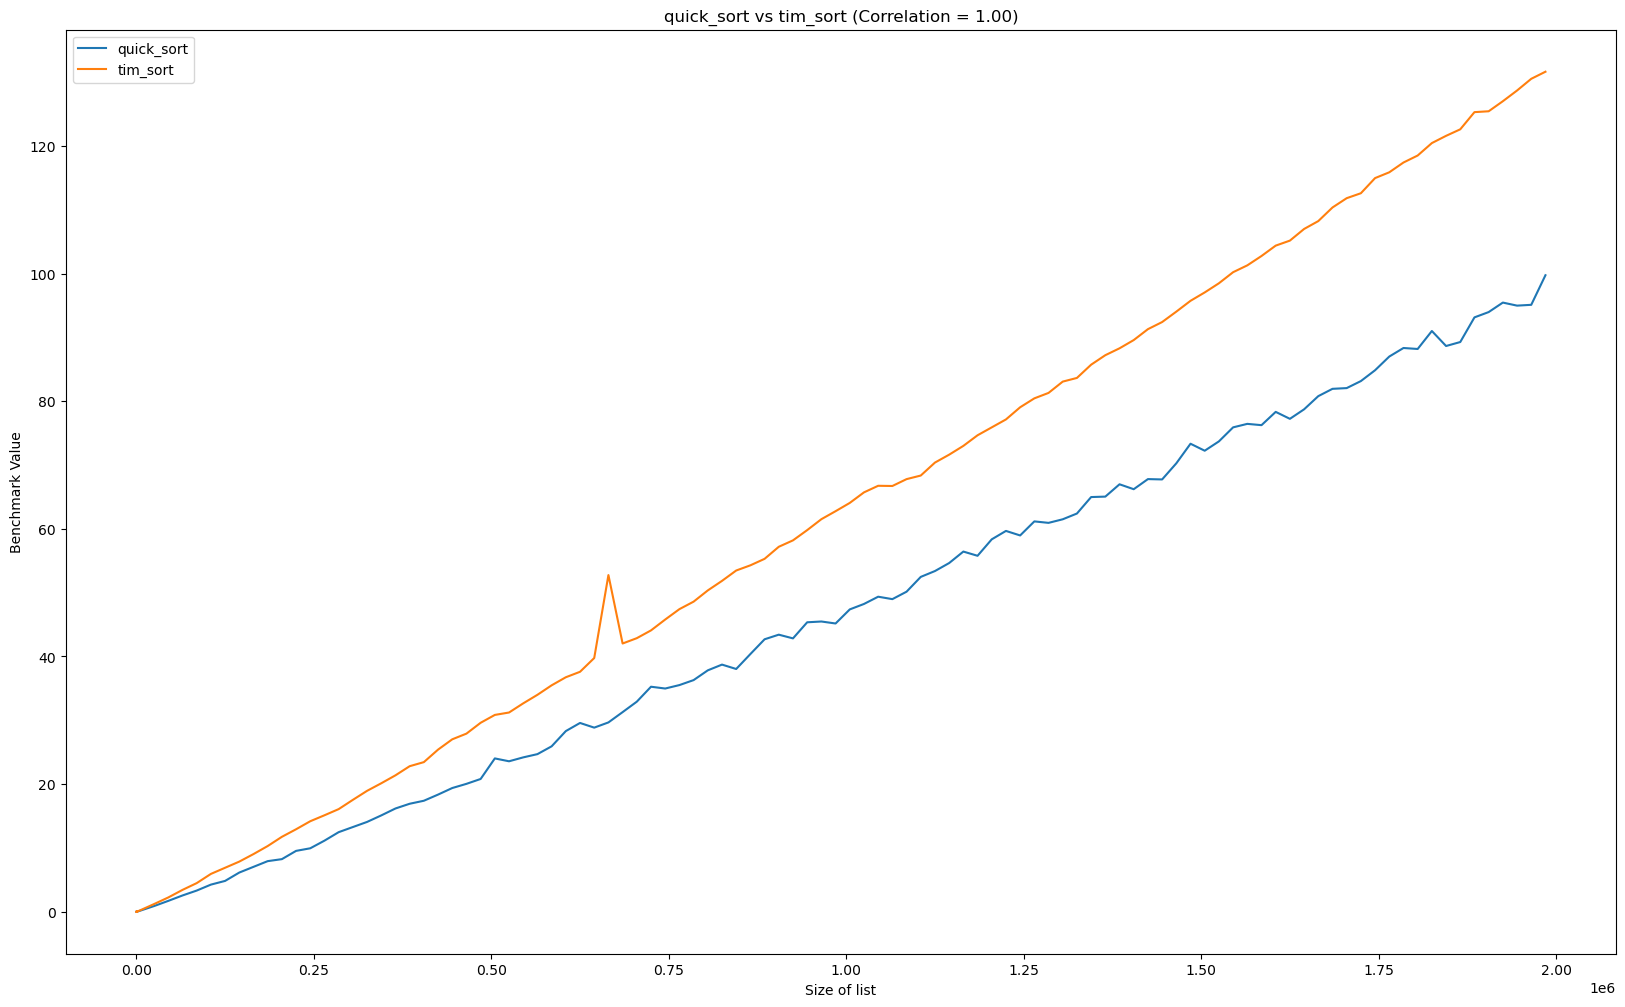

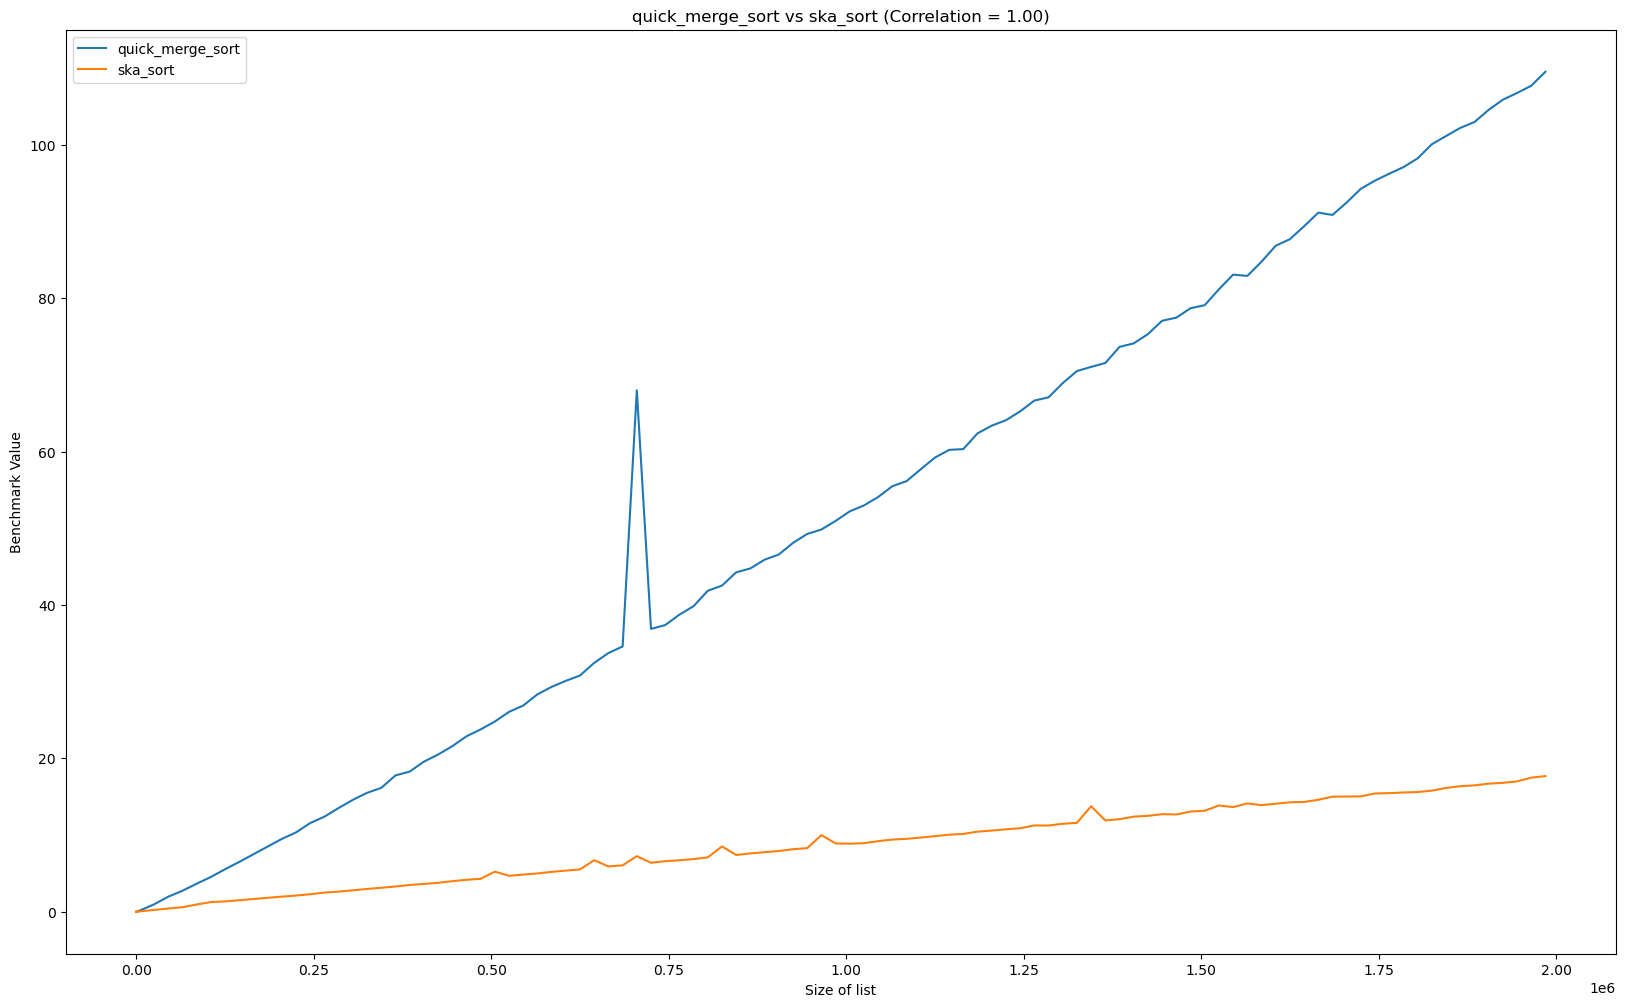

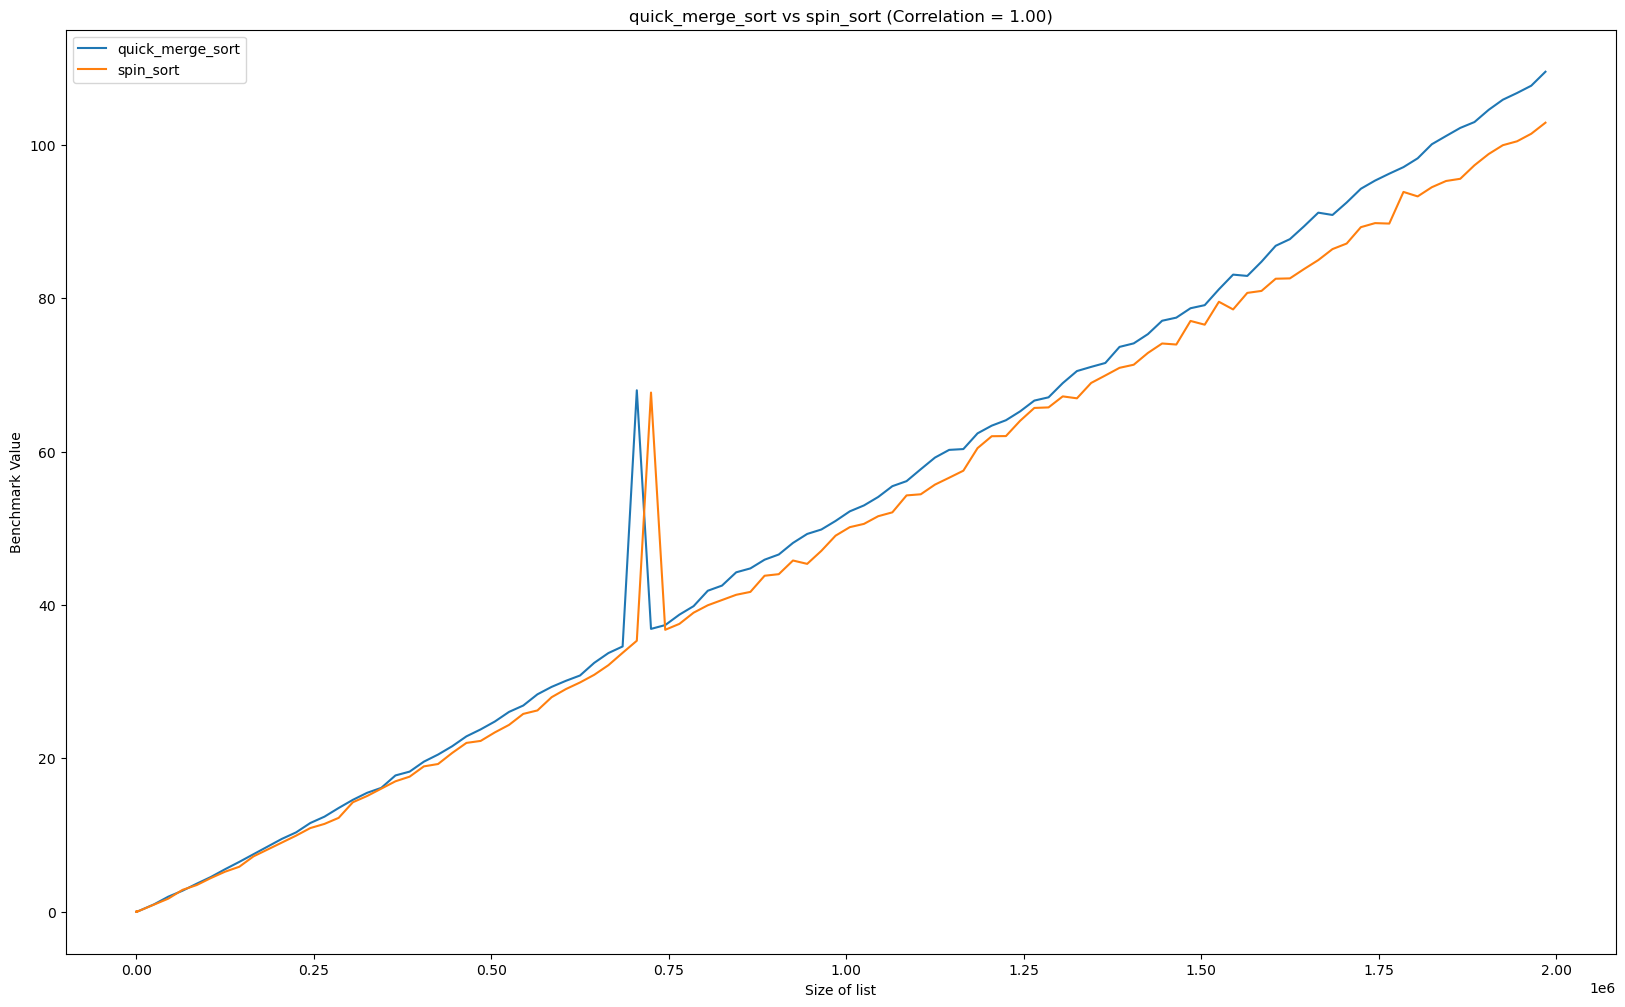

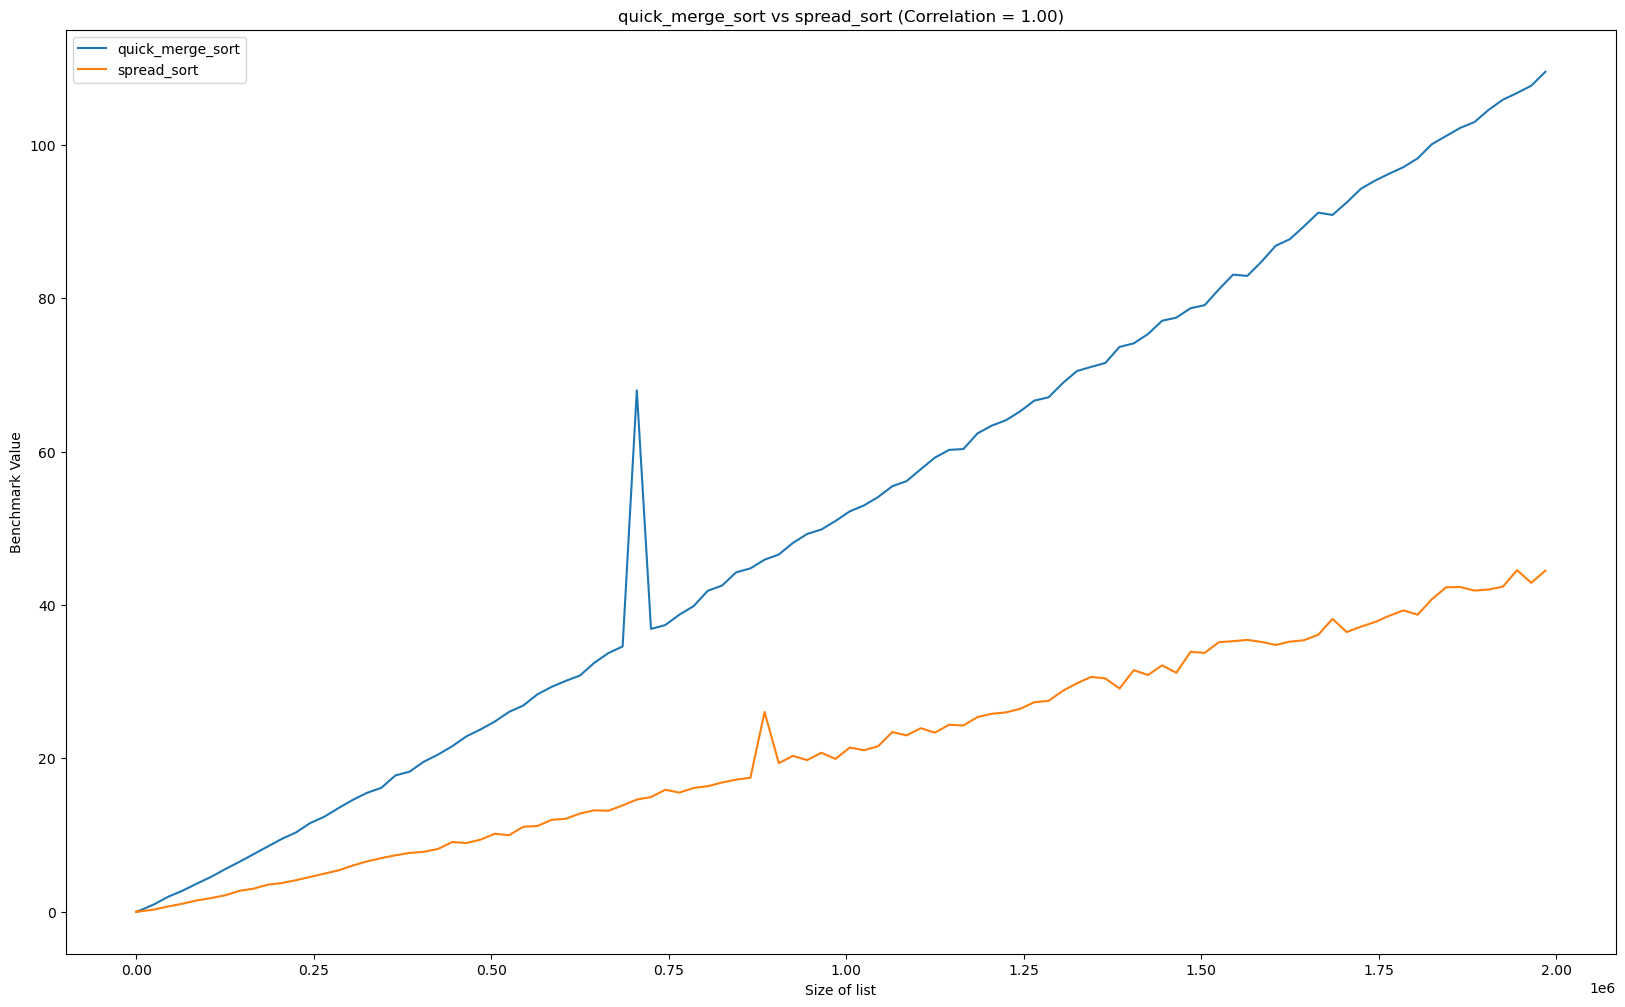

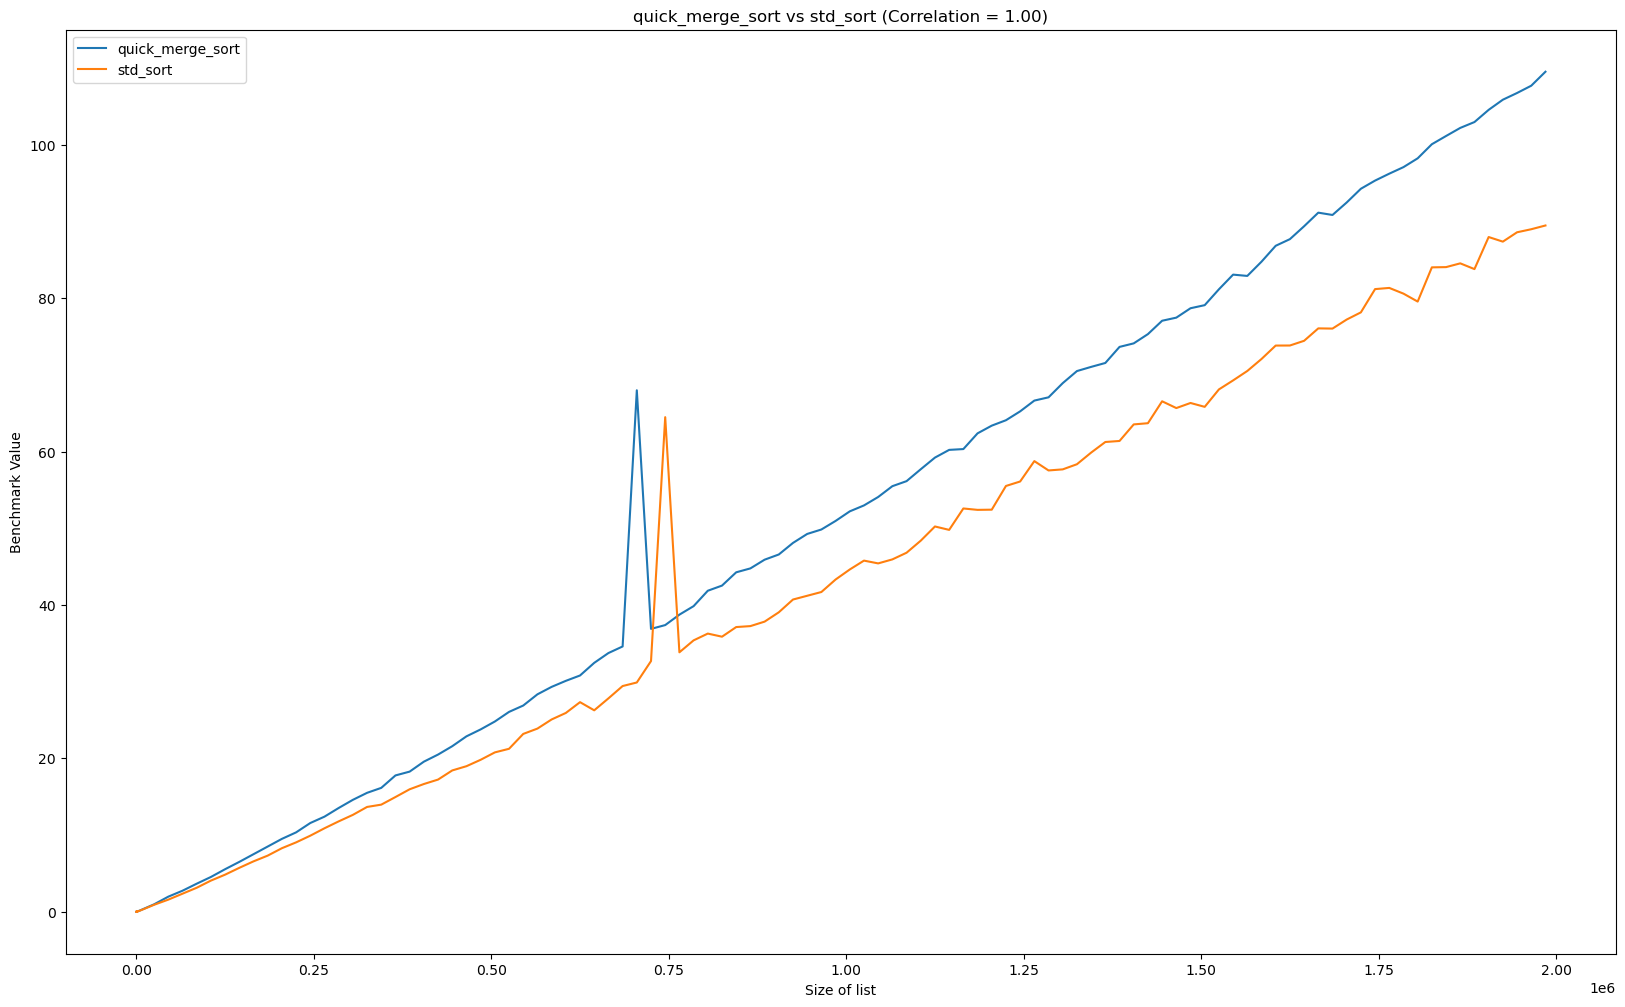

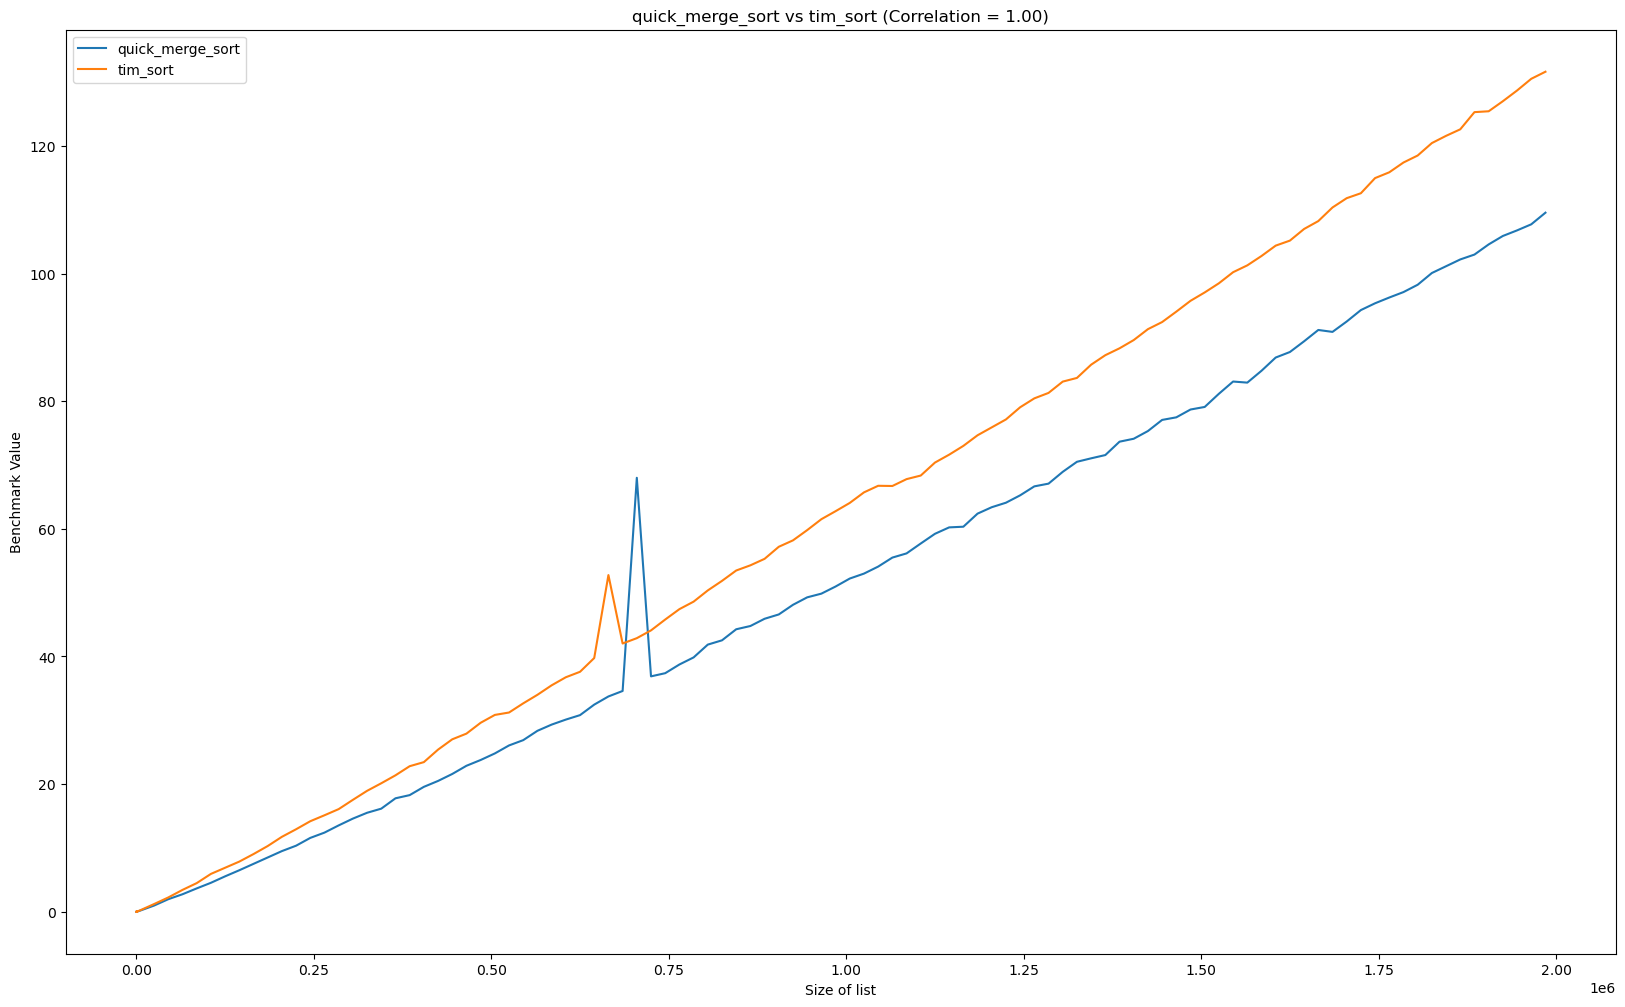

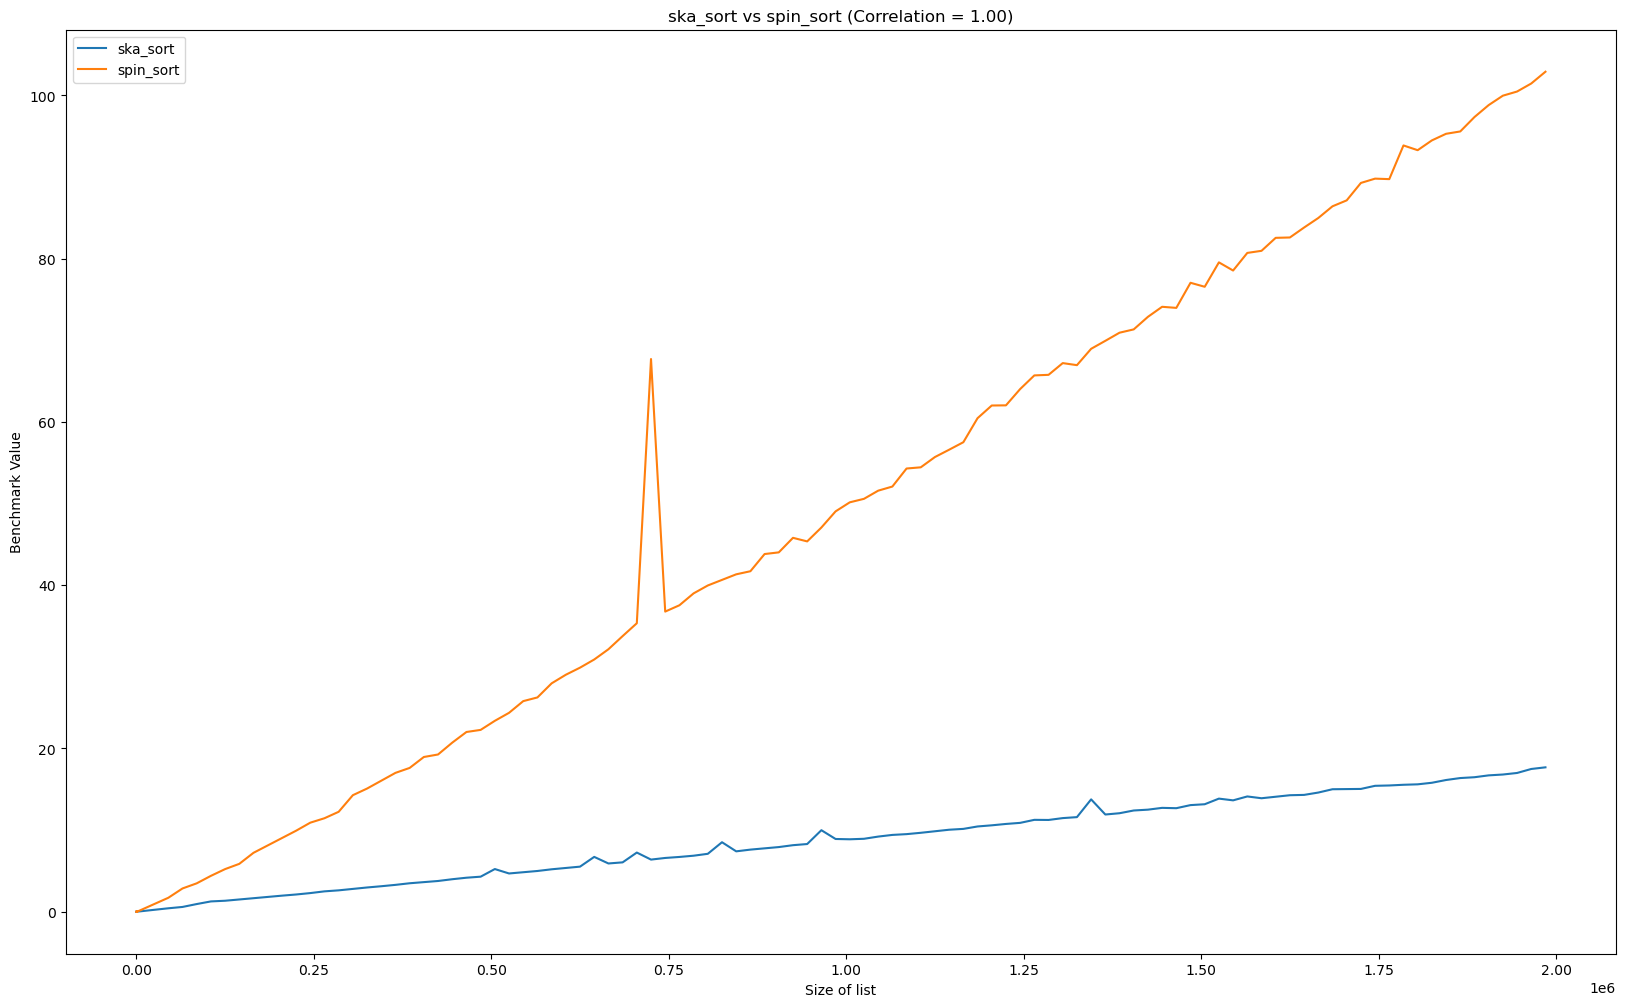

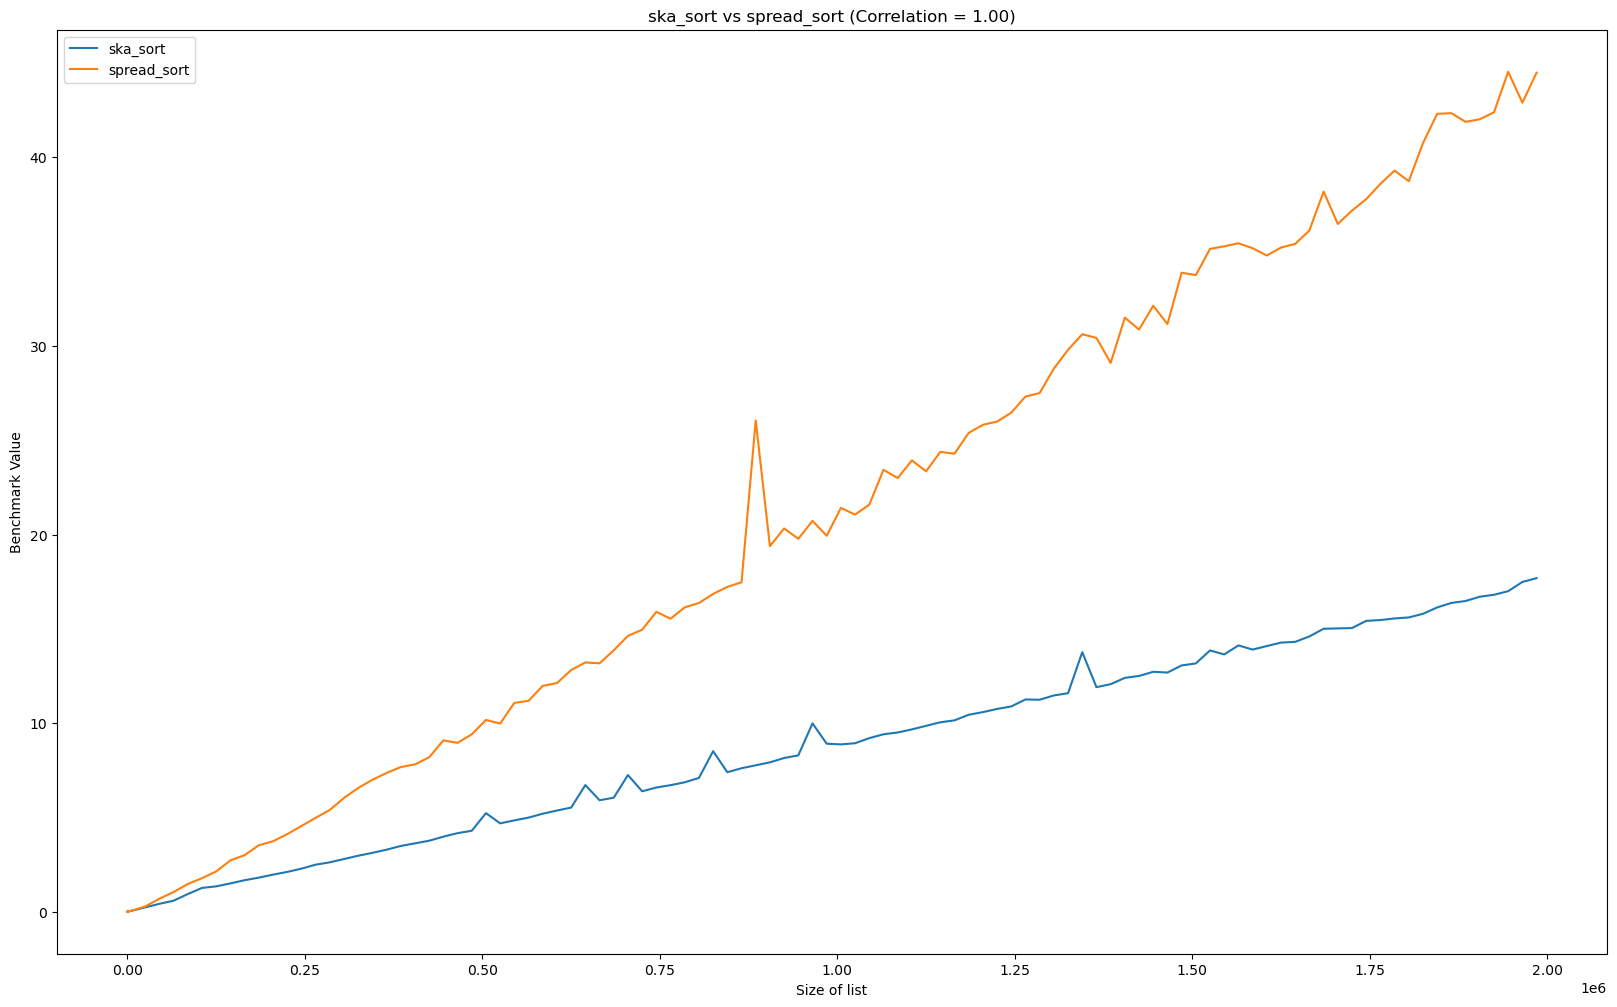

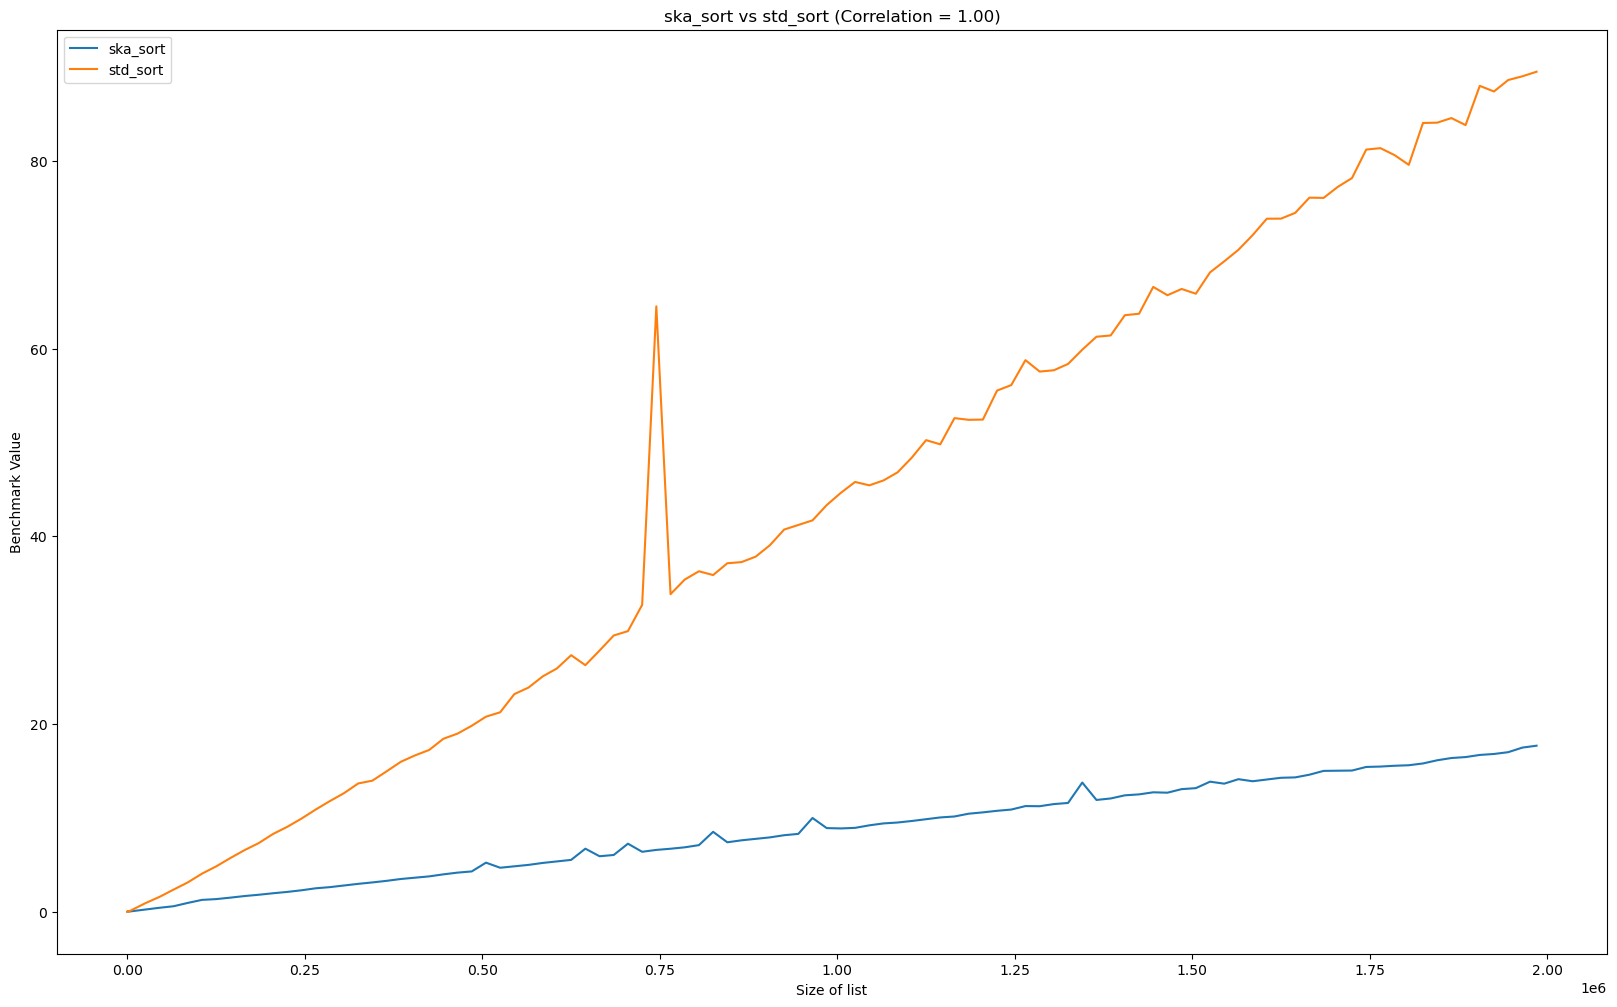

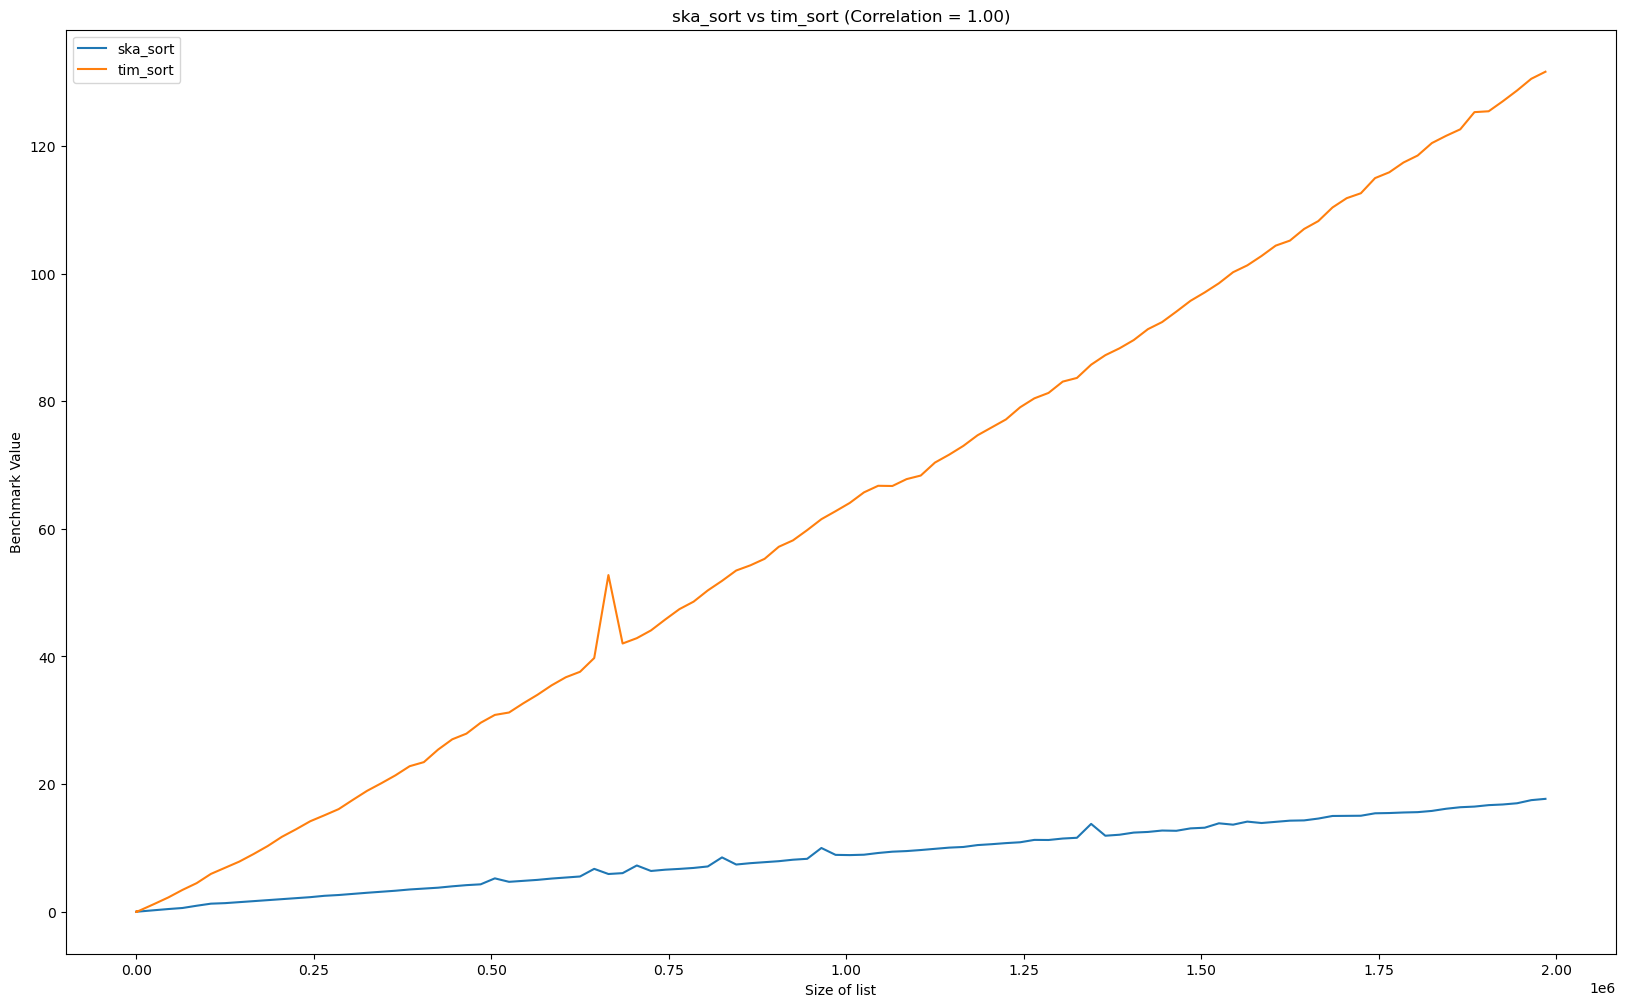

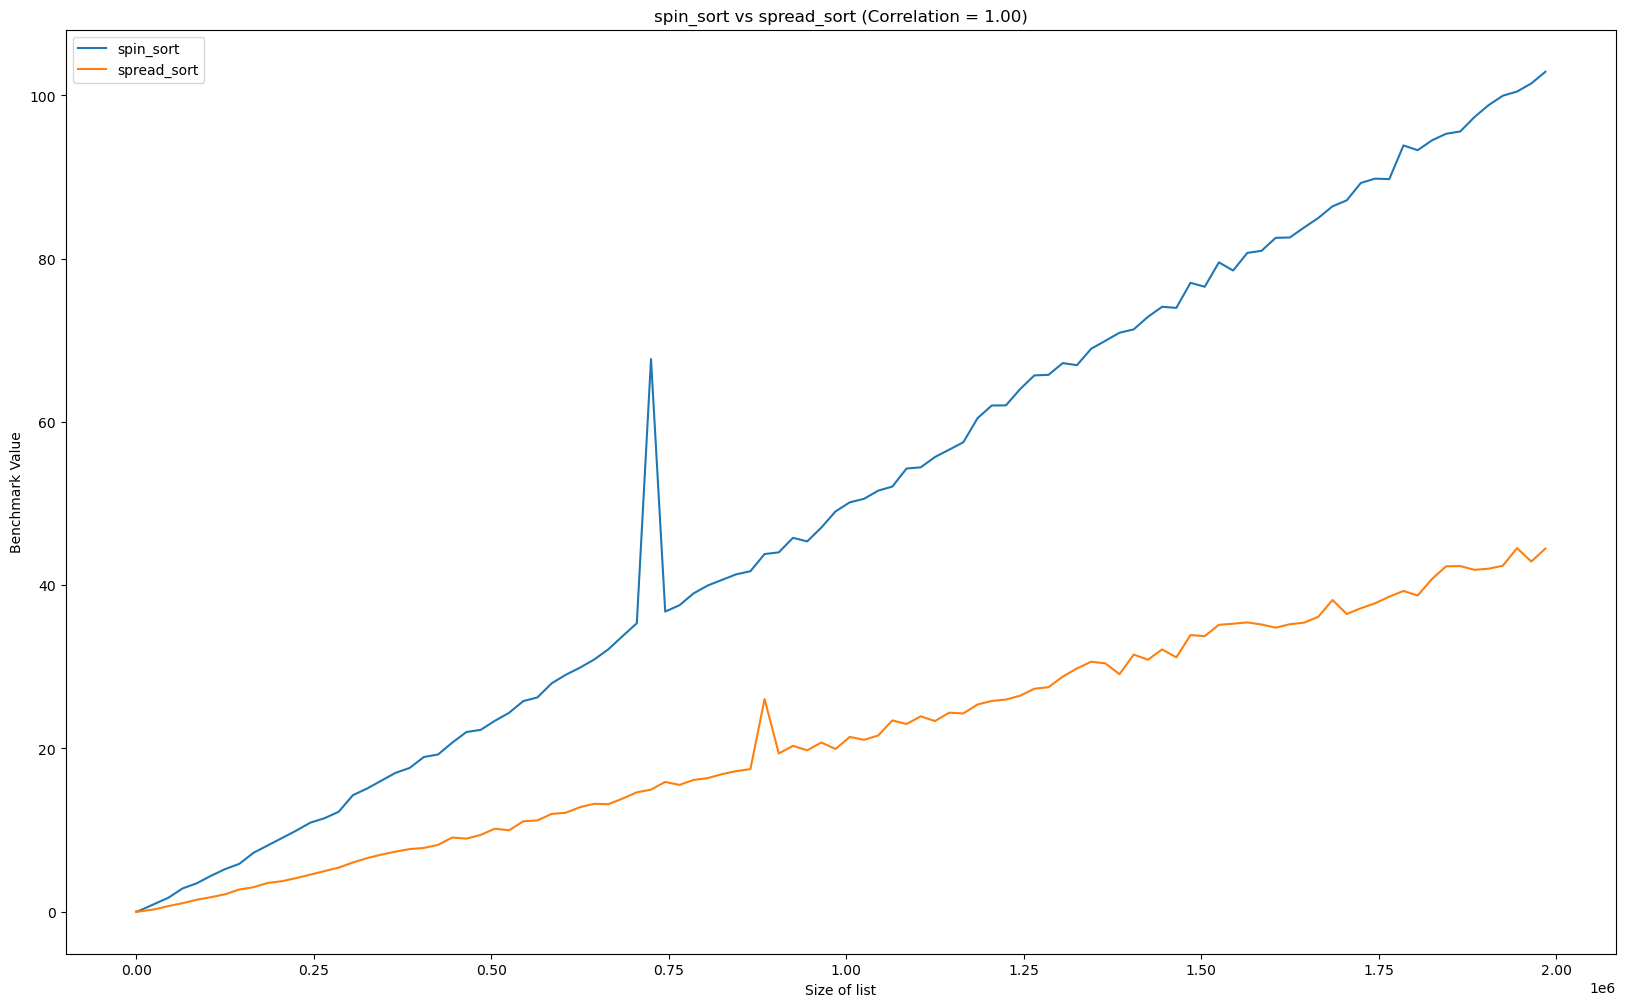

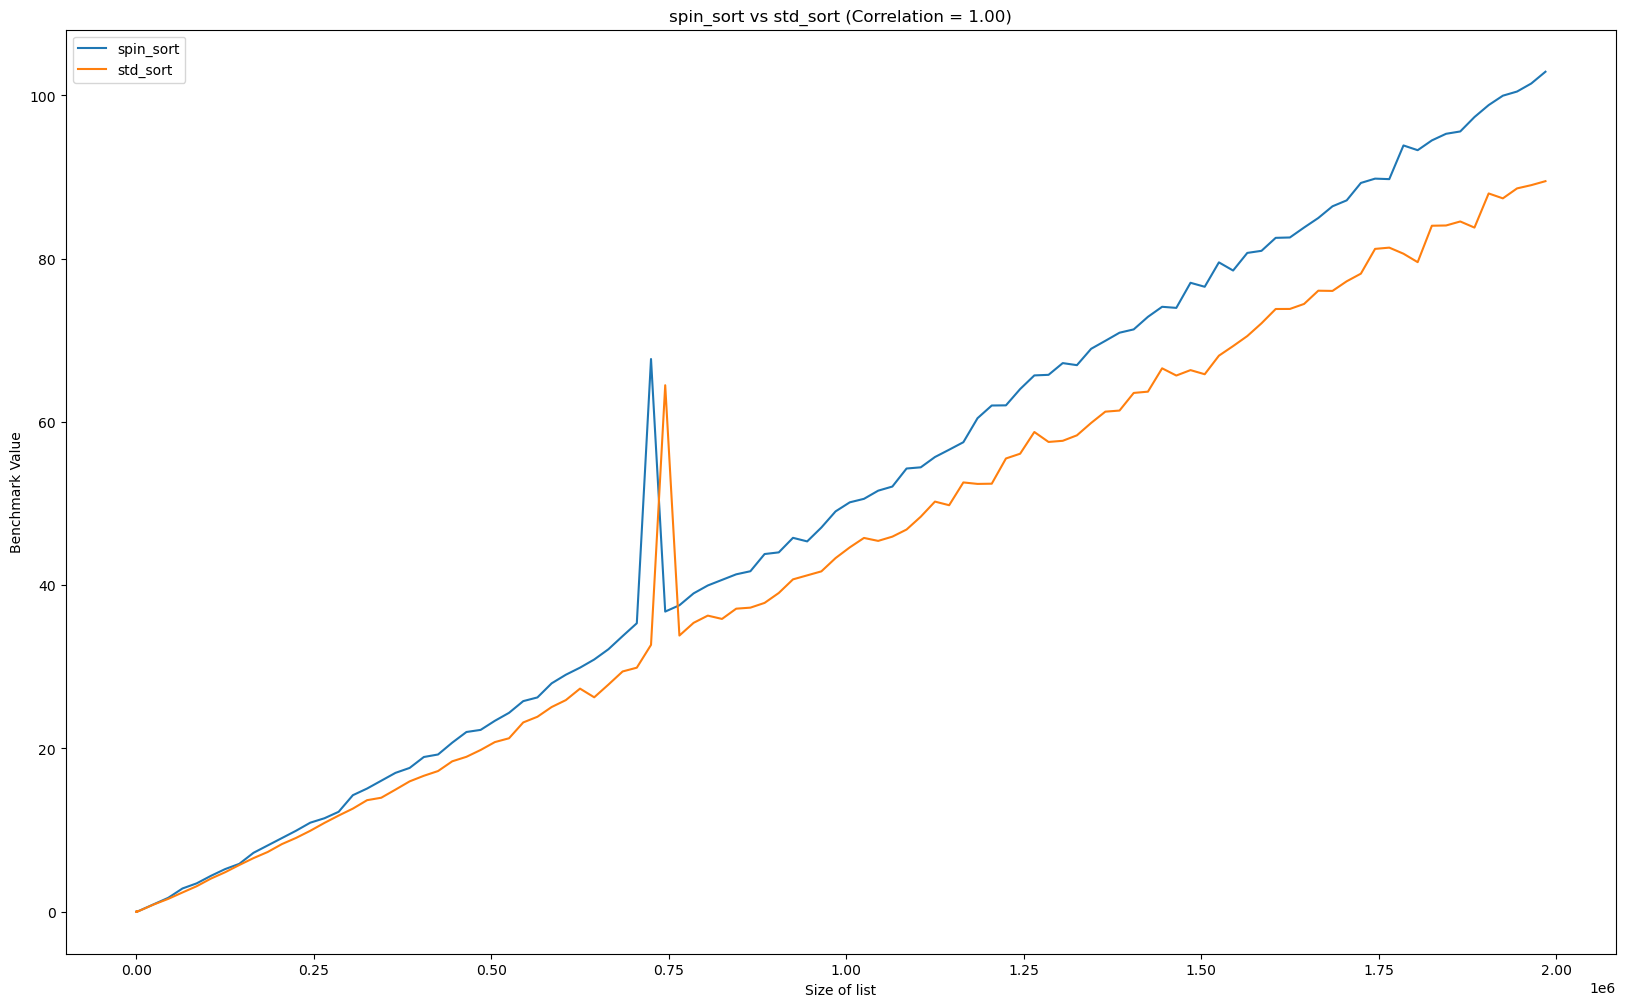

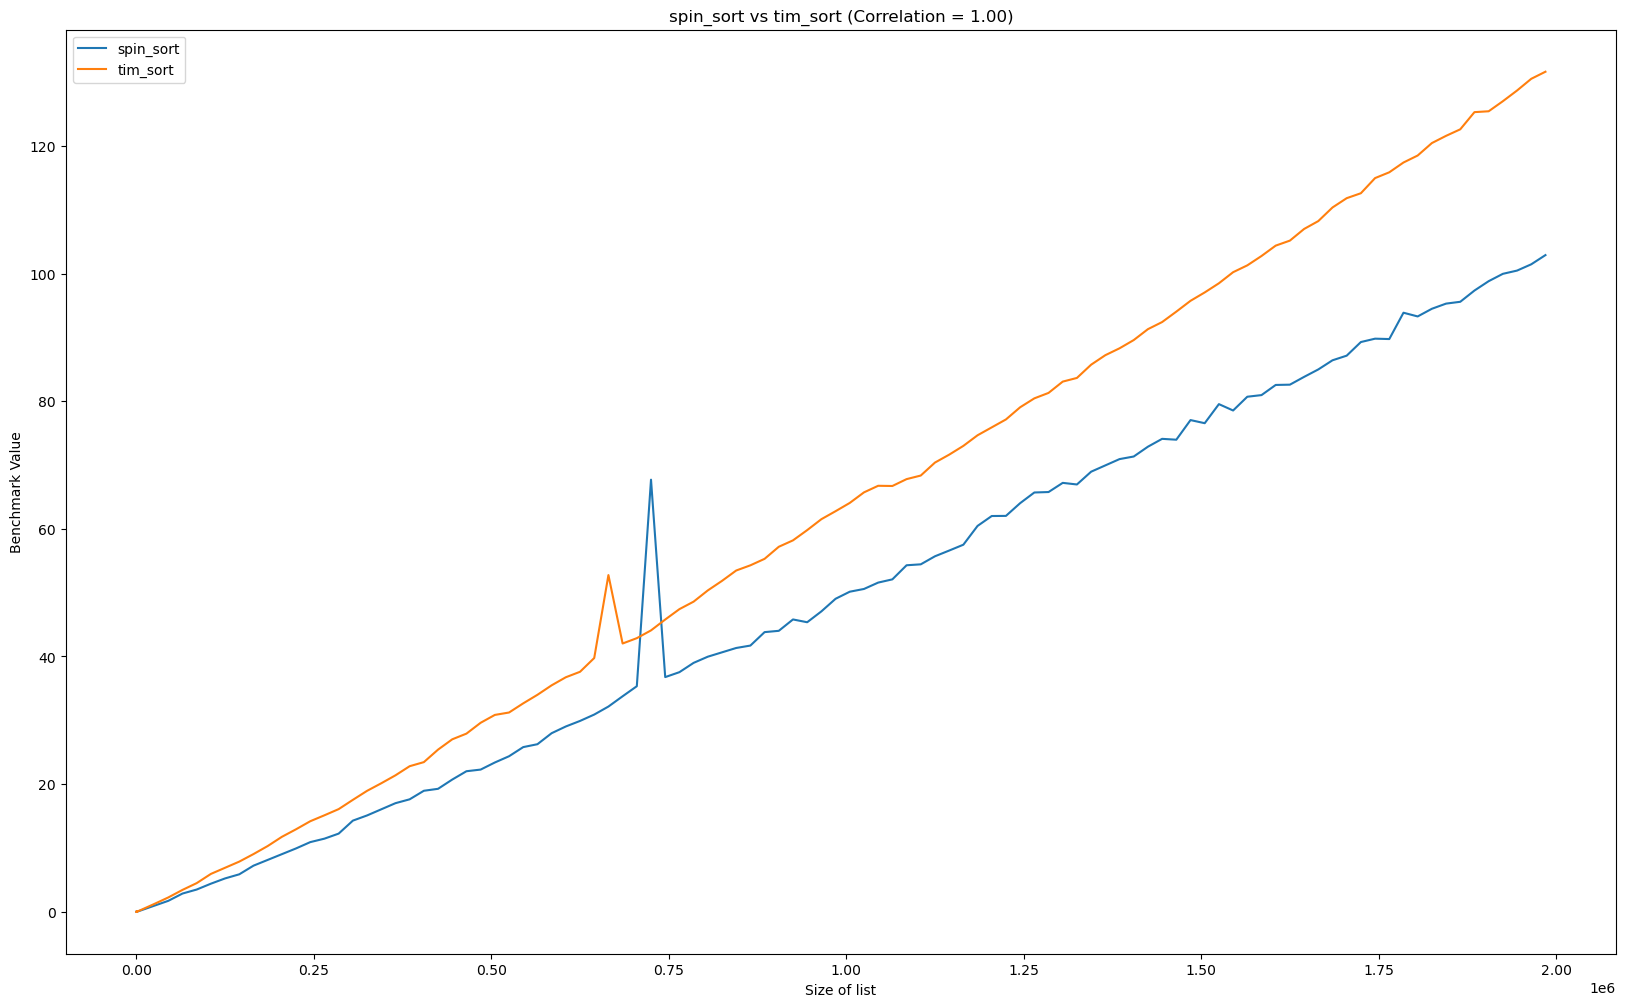

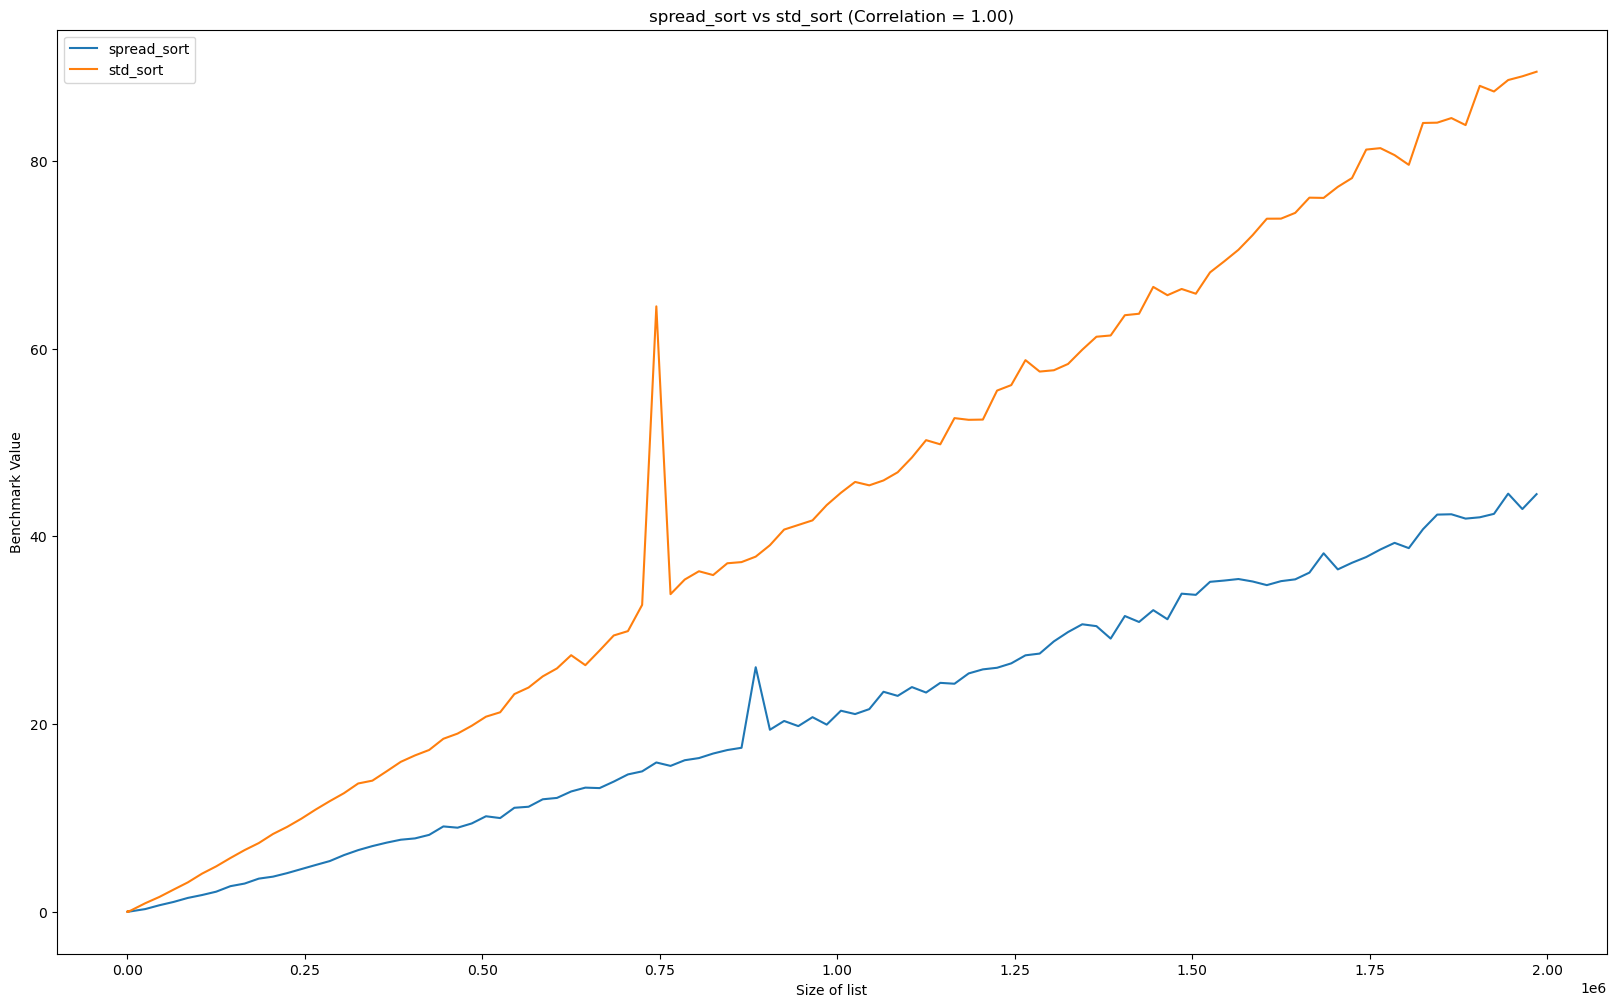

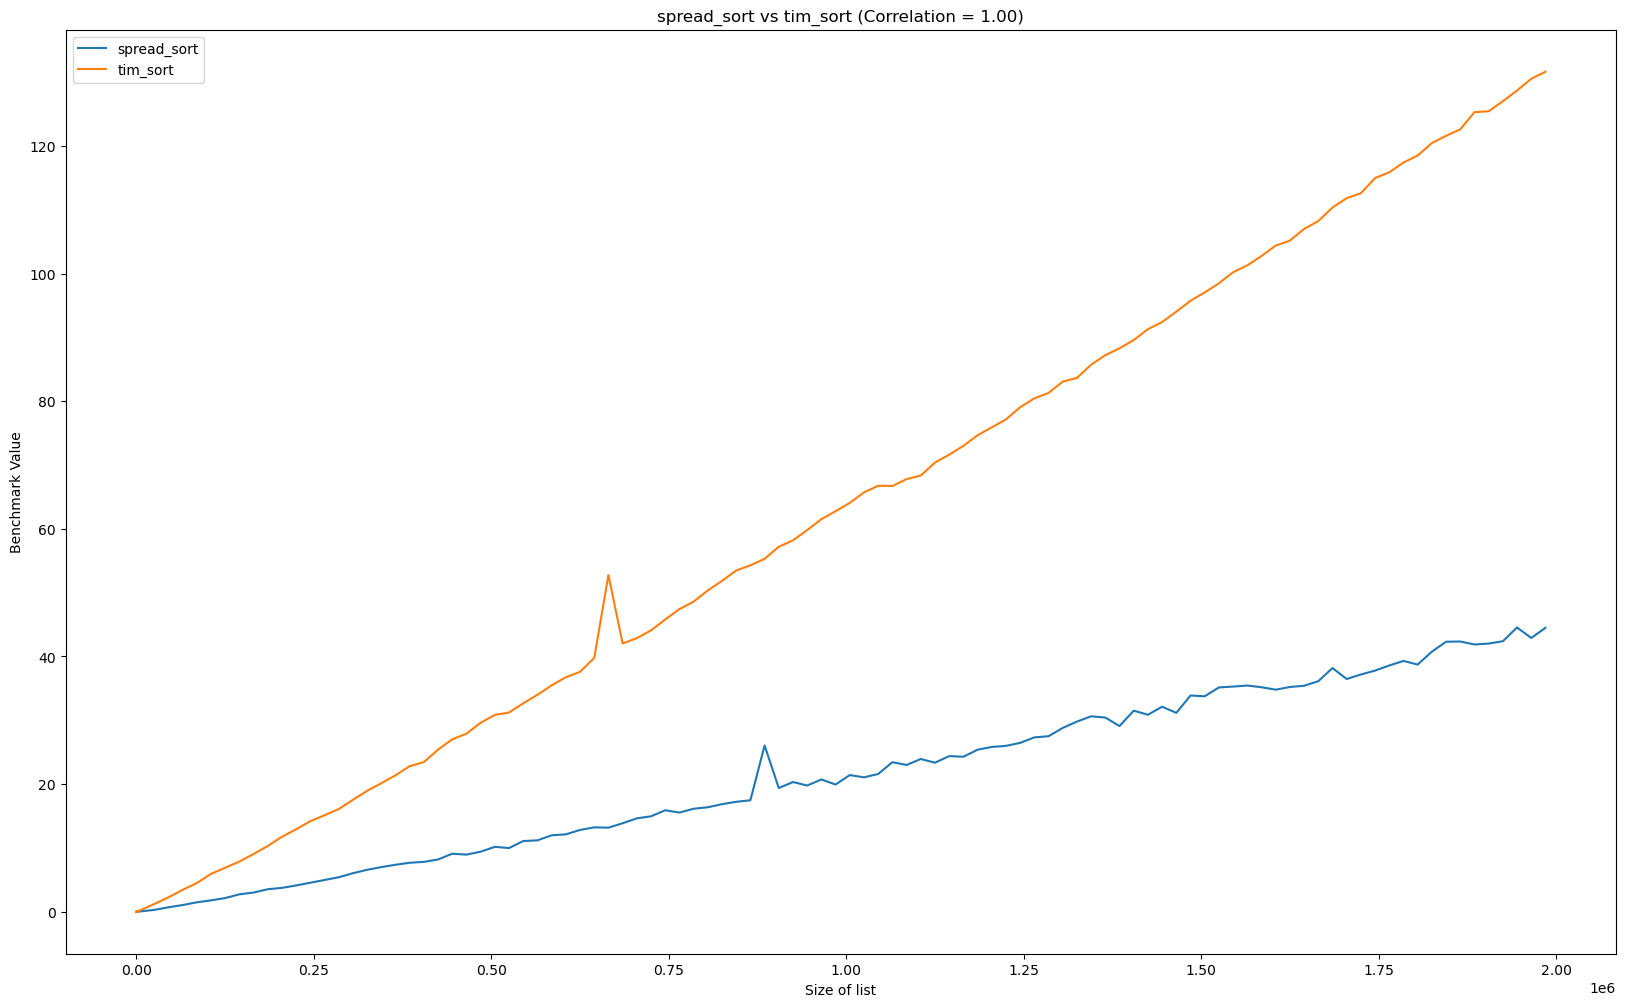

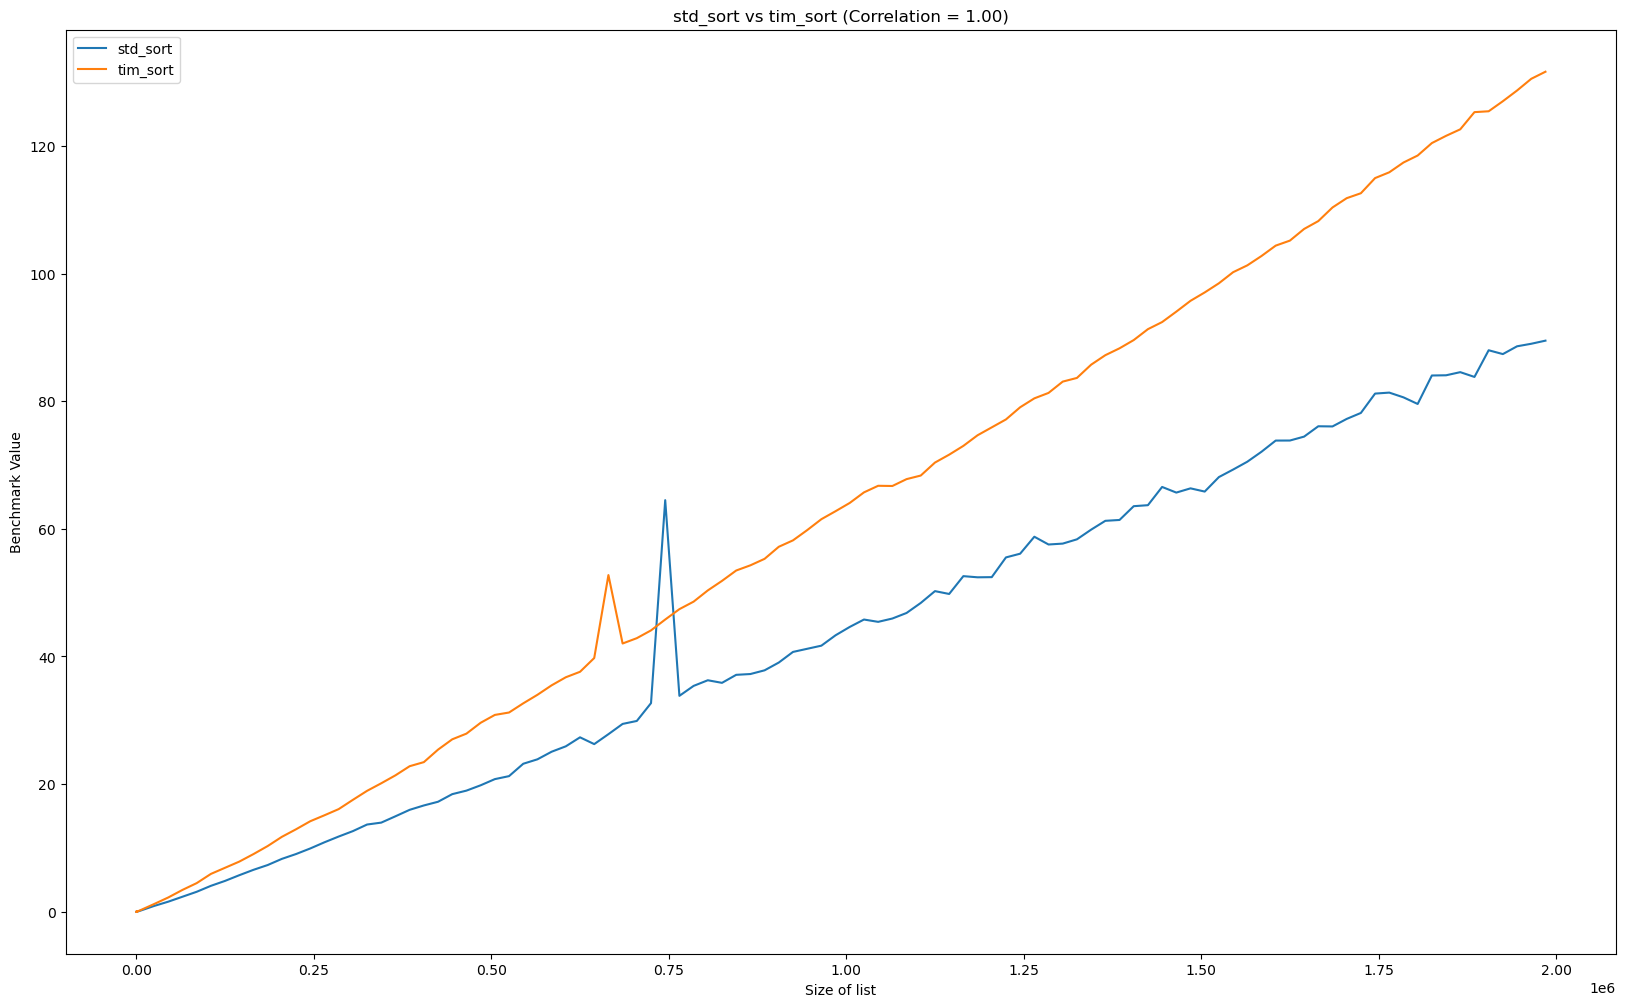

In [26]:
# Assuming benchmark_cols and corr_matrix are defined as before:
benchmark_cols = [col for col in df.columns if col != 'data']
corr_matrix = df[benchmark_cols].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
upper_tri = corr_matrix.where(mask)

high_corr_pairs = upper_tri.stack()[upper_tri.stack() > 0.95].index.tolist()

print("High correlation pairs (corr > 0.9):")
for col1, col2 in high_corr_pairs:
    print(f"{col1} and {col2} (corr = {corr_matrix.loc[col1, col2]:.2f})")

# Create a new column 'list_size' based on the size of each list in the 'data' column
df['list_size'] = df['data'].apply(len)

# Plot using the 'list_size' as the x-axis
for col1, col2 in high_corr_pairs:
    plt.figure(figsize=(20, 12))
    plt.plot(df['list_size'], df[col1], label=col1)
    plt.plot(df['list_size'], df[col2], label=col2)
    corr_value = corr_matrix.loc[col1, col2]
    plt.title(f'{col1} vs {col2} (Correlation = {corr_value:.2f})')
    plt.xlabel('Size of list')
    plt.ylabel('Benchmark Value')
    plt.legend()
    plt.show()


In [ ]:
benchmark_cols = [col for col in df.columns if col != 'data']
corr_matrix = df[benchmark_cols].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
upper_tri = corr_matrix.where(mask)

high_corr_pairs = upper_tri.stack()[upper_tri.stack() > 0.9].index.tolist()

print("High correlation pairs (corr > 0.9):")
for col1, col2 in high_corr_pairs:
    print(f"{col1} and {col2} (corr = {corr_matrix.loc[col1, col2]:.2f})")

In [ ]:
import pandas as pd

race_results = {}

for col1, col2 in high_corr_pairs:
    race_df = pd.DataFrame({
        f'{col1}_time': df[col1],
        f'{col2}_time': df[col2]
    })
    race_df[f'{col1}_winner'] = (race_df[f'{col1}_time'] < race_df[f'{col2}_time']).astype(int)
    race_results[(col1, col2)] = race_df

for pair, race_df in race_results.items():
    print(f"Race results for pair {pair}:")
    print(race_df.head(), "\n")

In [ ]:
import pandas as pd

race_results = {}

for col1, col2 in high_corr_pairs:
    race_df = pd.DataFrame({
        f'{col1}_time': df[col1],
        f'{col2}_time': df[col2]
    })
    race_df[f'{col1}_winner'] = (race_df[f'{col1}_time'] < race_df[f'{col2}_time']).astype(int)
    race_results[(col1, col2)] = race_df

threshold = 0.95  # Overwhelming win threshold (90%)
print("Pairs with an overwhelming winner:")
for pair, race_df in race_results.items():
    col1, col2 = pair
    win_rate = race_df[f'{col1}_winner'].mean()  # Fraction where col1 wins
    if win_rate >= threshold:
        print(f"{col1} overwhelmingly wins over {col2}: wins {win_rate*100:.1f}% of the races.")
    elif win_rate <= 1 - threshold:
        print(f"{col2} overwhelmingly wins over {col1}: wins {(1-win_rate)*100:.1f}% of the races.")

In [ ]:
from collections import defaultdict

threshold = 0.95
dominated_count = defaultdict(int)  # key = sort, value = number of sorts that dominate it

for (col1, col2), race_df in race_results.items():
    win_rate = race_df[f'{col1}_winner'].mean()
    
    # col1 dominates col2
    if win_rate >= threshold:
        dominated_count[col2] += 1
    
    # col2 dominates col1
    elif win_rate <= 1 - threshold:
        dominated_count[col1] += 1

# Print out how many sorts overwhelmingly outperform each sort
for sort_name, count in dominated_count.items():
    print(f"{sort_name} is overwhelmingly outperformed by {count} sorts.")
